# Model South Korea Time Series for COVID : Training

This notebook creates a LSTM Tensorflow model to predict confirmed covid-19 cases in South Korea.  
It retrieves data from Korean gouvernment, explores features, creates & trains model.  

Not in this notebook : 
- This model will be converted into Tensorflow Lite here :
ModelCovidTimeSeries-convert-publish-KR.ipynb 
- It will be use in a serverless AWS Lambda function to predict confirmed cases for my web app [app-covid-visu](http://app-covid-visu.coolplace.fr/) 
 
The time series model is created and trained to predict future 7 next days (output) based on 14 past last days (input). 

**Input Features are daily data of:**

- Min/Max Temperatures
- Mean Humidities
- Mean Wind speed
- nb. Confirmed cases
- nb. Tested cases
- Day of the week
- Mean Age of Confirmed cases

**DATA sources:**

- Tested / Confirmed cases KR: https://www.data.go.kr/tcs/dss/selectApiDataDetailView.do?publicDataPk=15043376
- Confirmed cases by age KR: https://www.data.go.kr/tcs/dss/selectApiDataDetailView.do?publicDataPk=15043377
- Confirmed cases by area KR: https://www.data.go.kr/tcs/dss/selectApiDataDetailView.do?publicDataPk=15043378
- Meteo South Korea (Seoul, Deagu, Busan): https://www.visualcrossing.com/weather-data


**GitHub:** https://github.com/jeugregg/coronavirusModel

## Settings notebook

In [1]:
mode_collect = True # True : retrieve data online (set TRAIN_SPLIT in model_kr)
mode_train = True # True : Train model

## import

In [2]:
%matplotlib inline

# figure lib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
sns.set(color_codes=True, font_scale=1.33)
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# data useful lib
import pandas as pd
import numpy as np

# helper lib
import shutil
import os, stat
import re
import datetime
import math

# read json from http
import json
import urllib.request

# read csv from http
import io
import requests

# model lib
import tensorflow as tf
from sklearn.metrics import mean_absolute_error

# projects libs
import settings
from my_helpers.data_plots_kr import update_df_feat_kr
from my_helpers.data_plots_kr import load_df_feat_kr

from my_helpers.model import multivariate_data
from my_helpers.model import prepare_to_lambda
from my_helpers.model import retrieve_from_lambda
from my_helpers.model import create_list_past_hist
from my_helpers.model import predict_list

from my_helpers.dates import add_days
from my_helpers.dates import generate_list_dates

from my_helpers.model_kr import prepare_data_features_kr
from my_helpers.model_kr import prepare_dataset_kr

In [3]:
tf.__version__ 

'2.5.0'

## Definitions

In [4]:
#PATH_DF_FEAT_KR = PATH_TO_SAVE_DATA + '/' + 'df_feat_fr.csv' 
PATH_TO_SAVE_DATA = settings.PATH_TO_SAVE_DATA
from my_helpers.model_kr import PATH_MDL_MULTI_STEP_KR
#PATH_MDL_MULTI_STEP_KR = PATH_TO_SAVE_DATA + '/' + "mdl_multi_step_pos_kr"

#PATH_MDL_MULTI_TFLITE = PATH_TO_SAVE_DATA + '/' + \
#    'serverless/tensorflow_lite_on_aws_lambda'
#PATH_MDL_MULTI_TFLITE_FILE = PATH_MDL_MULTI_TFLITE + '/' + \
#    "converted_model.tflite"
#PATH_SERVERLESS = PATH_MDL_MULTI_TFLITE + '/' + 'serverless.yml'

#date_format = "%Y-%m-%d"

#NB_POS_DATE_MIN_DF_FEAT = 140734 # on 13/05/2020
#NB_POS_DATE_MIN_DF_FEAT = 140227 # on 12/05/2020

#URL_PREDICT = 'https://yl0910jrga.execute-api.us-east-2.amazonaws.com/dev/infer'

# model 
from my_helpers.model_kr import PAST_HISTORY # days used to predict next values in future
from my_helpers.model_kr import FUTURE_TARGET  # predict 3 days later
from my_helpers.model_kr import STEP 


##  Helper functions

In [5]:
# FOR MODEL
# For Training plots
def create_time_steps(length):
    '''
    create time steps
    '''
    return list(range(-length, 0))

def plot_train_history(history, title):
    """
    Plot train errors
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()



def prepare_data_features_kr_old(df_feat_kr):
    df_out = df_feat_kr.copy().filter(items=["date", 'nb_cases', 
                                             'T_min', 'T_max', 'H_mean',
                                           'W_speed', 'pos', 'test', 'day_num',
                                           'age_pos'])
    df_out.fillna(method="pad", inplace=True)
    df_out.dropna(inplace=True)
    date_old = add_days(df_out.index[0].strftime("%Y-%m-%d"), -1)
    dates_index =  df_out.index.strftime("%Y-%m-%d")
    for date_curr in dates_index:
        if date_curr != add_days(date_old, 1):
            print("ERROR : ", date_curr)
            #break
        assert date_curr == add_days(date_old, 1)
        date_old = date_curr
    return df_out

## Retrieve data

In [6]:
if mode_collect:
    df_feat_kr = update_df_feat_kr()
    df_feat_kr

Updating Data KR...
update cases :  True
update age :  True
date_req_start:  2021-09-27
date_req_start_age:  2021-09-27
date_req_end:  2021-10-03
http://openapi.data.go.kr/openapi/service/rest/Covid19/getCovid19InfStateJson?serviceKey=vdvTqgH%2ByZyoebTbIuQVedRNSnB9aP0IuNFfD4uIRnhALu4%2FUkxCDZSHp2Qx2S4IOfN3P3nJCQJbTbxk%2FdMAlA%3D%3D&startCreateDt=20210927&endCreateDt=20211003
nb. new items:  7
http://openapi.data.go.kr/openapi/service/rest/Covid19/getCovid19SidoInfStateJson?serviceKey=vdvTqgH%2ByZyoebTbIuQVedRNSnB9aP0IuNFfD4uIRnhALu4%2FUkxCDZSHp2Qx2S4IOfN3P3nJCQJbTbxk%2FdMAlA%3D%3D&startCreateDt=20210927&endCreateDt=20211003
nb. new items:  133
https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/weatherdata/history?aggregateHours=24&combinationMethod=aggregate&startDateTime=2021-09-27T00%3A00%3A00&endDateTime=2021-10-03T00%3A00%3A00&maxStations=-1&maxDistance=-1&shortColumnNames=true&sendAsDatasource=true&contentType=csv&unitGroup=metric&locationMode=array&key=7XN

/Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/my_helpers/model.py:119: RuntimeWarning:

divide by zero encountered in true_divide

/Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/my_helpers/model.py:119: RuntimeWarning:

invalid value encountered in true_divide



File /Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/df_feat_kr_old.csv moved!


## Reload data

In [7]:
df_feat_kr = load_df_feat_kr()
df_feat_kr

nb_cases    nb_tests  nb_deaths        date  day_num  Jeju  \
date                                                                     
2020-02-02       2.0         0.0        2.0  2020-02-02      0.0   NaN   
2020-02-03      15.0         0.0        0.0  2020-02-03      1.0   NaN   
2020-02-04       0.0         0.0        0.0  2020-02-04      2.0   NaN   
2020-02-05      19.0         0.0        0.0  2020-02-05      3.0   NaN   
2020-02-06      23.0         0.0        0.0  2020-02-06      4.0   NaN   
...              ...         ...        ...         ...      ...   ...   
2021-09-29  308723.0  13347641.0     2474.0  2021-09-29      3.0   5.0   
2021-09-30  311286.0  13394597.0     2481.0  2021-09-30      4.0  15.0   
2021-10-01  313772.0  13427198.0     2497.0  2021-10-01      5.0   9.0   
2021-10-02  316020.0  13465168.0     2504.0  2021-10-02      6.0   8.0   
2021-10-03  318105.0  13472249.0     2507.0  2021-10-03      0.0   5.0   

            Gyeongnam  Gyeongbuk  Jeonnam  Jeonbuk  ...  sum_Jeonbuk  \
date                                                ...                
2020-02-02        NaN        NaN      NaN      NaN  ...          NaN   
2020-02-03        NaN        NaN      NaN      NaN  ...          NaN   
2020-02-04        NaN        NaN      NaN      NaN  ...          NaN   
2020-02-05        NaN        NaN      NaN      NaN  ...          NaN   
2020-02-06        NaN        NaN      NaN      NaN  ...          NaN   
...               ...        ...      ...      ...  ...          ...   
2021-09-29       84.0       88.0     23.0     41.0  ...        587.0   
2021-09-30       67.0       52.0     24.0     35.0  ...        602.0   
2021-10-01       69.0       60.0     29.0     32.0  ...        598.0   
2021-10-02      108.0       56.0     22.0     23.0  ...        548.0   
2021-10-03       65.0       97.0     25.0     29.0  ...        557.0   

            Rt_Jeonbuk  sum_Jeonnam  Rt_Jeonnam  sum_Gyeongbuk  Rt_Gyeongbuk  \
date                                                                           
2020-02-02         NaN          NaN         NaN            NaN           NaN   
2020-02-03         NaN          NaN         NaN            NaN           NaN   
2020-02-04         NaN          NaN         NaN            NaN           NaN   
2020-02-05         NaN          NaN         NaN            NaN           NaN   
2020-02-06         NaN          NaN         NaN            NaN           NaN   
...                ...          ...         ...            ...           ...   
2021-09-29    2.096429        218.0    0.968889          672.0      1.476923   
2021-09-30    2.134752        234.0    1.063636          691.0      1.549327   
2021-10-01    2.062069        250.0    1.146789          713.0      1.627854   
2021-10-02    1.626113        265.0    1.358974          745.0      1.765403   
2021-10-03    1.623907        278.0    1.455497          801.0      1.902613   

            sum_Gyeongnam  Rt_Gyeongnam  sum_Jeju   Rt_Jeju  
date                                                         
2020-02-02            NaN           NaN       NaN       NaN  
2020-02-03            NaN           NaN       NaN       NaN  
2020-02-04            NaN           NaN       NaN       NaN  
2020-02-05            NaN           NaN       NaN       NaN  
2020-02-06            NaN           NaN       NaN       NaN  
...                   ...           ...       ...       ...  
2021-09-29          658.0      0.937322     117.0  0.893130  
2021-09-30          692.0      1.016153     121.0  0.923664  
2021-10-01          726.0      1.091729     121.0  0.930769  
2021-10-02          791.0      1.205793     126.0  1.008000  
2021-10-03          834.0      1.332268     125.0  1.008065  

[610 rows x 87 columns]

In [8]:
df_feat_kr.filter(items=["date", 'T_min', 'T_max', 'H_mean',
    'pos', 'test', 'day_num', 'age_pos', 
    'W_mean'])[df_feat_kr["date"] >= "2020-04-03"].head()

date     T_min      T_max     H_mean   pos     test  \
date                                                                    
2020-04-03  2020-04-03  5.233333  18.833333  46.640000  86.0  10507.0   
2020-04-04  2020-04-04  5.266667  18.000000  44.216667  94.0  10523.0   
2020-04-05  2020-04-05  2.633333  14.733333  36.973333  81.0   6774.0   
2020-04-06  2020-04-06  2.133333  16.633333  44.676667  47.0   5847.0   
2020-04-07  2020-04-07  6.900000  19.600000  47.673333  47.0   9145.0   

            day_num    age_pos  
date                            
2020-04-03      5.0  41.898165  
2020-04-04      6.0  41.898165  
2020-04-05      0.0  41.898165  
2020-04-06      1.0  41.898165  
2020-04-07      2.0  41.898165

In [9]:
df_feat_kr.filter(items=["date", 'T_min', 'T_max', 'H_mean',
    'pos', 'test', 'day_num', 'age_pos', 
    'W_speed'])[df_feat_kr["date"] >= "2020-06-10"].head()

date      T_min      T_max     H_mean   pos     test  \
date                                                                     
2020-06-10  2020-06-10  20.566667  32.766667  58.493333  50.0  17211.0   
2020-06-11  2020-06-11  21.633333  30.233333  75.713333  45.0  15645.0   
2020-06-12  2020-06-12  21.266667  29.033333  76.100000  56.0  15849.0   
2020-06-13  2020-06-13  20.733333  29.400000  73.890000  48.0  14109.0   
2020-06-14  2020-06-14  21.933333  28.733333  78.003333  34.0   7620.0   

            day_num    age_pos    W_speed  
date                                       
2020-06-10      3.0  51.110000  19.666667  
2020-06-11      4.0  45.177778  15.500000  
2020-06-12      5.0        NaN  16.566667  
2020-06-13      6.0  52.052885  16.900000  
2020-06-14      0.0  47.750000  23.400000

## Filter good data

In [10]:
df_feat_kr = prepare_data_features_kr(df_feat_kr)

df_feat_kr[df_feat_kr["date"] >= "2020-06-10"].head()

nb_cases   nb_tests  nb_deaths        date  day_num  Jeju  \
date                                                                    
2020-06-10   11902.0  1025748.0      276.0  2020-06-10      3.0   0.0   
2020-06-11   11947.0  1041393.0      276.0  2020-06-11      4.0   0.0   
2020-06-12   12003.0  1057242.0      277.0  2020-06-12      5.0   0.0   
2020-06-13   12051.0  1071351.0      277.0  2020-06-13      6.0   0.0   
2020-06-14   12085.0  1078971.0      277.0  2020-06-14      0.0   0.0   

            Gyeongnam  Gyeongbuk  Jeonnam  Jeonbuk  ...  sum_Jeonbuk  \
date                                                ...                
2020-06-10        2.0        0.0      0.0      0.0  ...          0.0   
2020-06-11        0.0        0.0      0.0      0.0  ...          0.0   
2020-06-12        0.0        0.0      0.0      0.0  ...          0.0   
2020-06-13        0.0        0.0      0.0      0.0  ...          0.0   
2020-06-14        0.0        0.0      0.0      0.0  ...          0.0   

            Rt_Jeonbuk  sum_Jeonnam  Rt_Jeonnam  sum_Gyeongbuk  Rt_Gyeongbuk  \
date                                                                           
2020-06-10         0.0          2.0         1.0            5.0      0.454545   
2020-06-11         0.0          2.0         2.0            4.0      0.363636   
2020-06-12         0.0          2.0         inf            4.0      0.363636   
2020-06-13         0.0          1.0         1.0            4.0      0.363636   
2020-06-14         0.0          1.0         1.0            4.0      0.363636   

            sum_Gyeongnam  Rt_Gyeongnam  sum_Jeju  Rt_Jeju  
date                                                        
2020-06-10            4.0           1.0       1.0      inf  
2020-06-11            4.0           1.0       1.0      inf  
2020-06-12            4.0           1.0       1.0      inf  
2020-06-13            4.0           1.0       1.0      inf  
2020-06-14            4.0           2.0       0.0      0.0  

[5 rows x 87 columns]

## Train/Test split

In [11]:
if mode_collect:
    # keep 20% Validation samples:
    TRAIN_SPLIT = df_feat_kr.shape[0] - (2 * FUTURE_TARGET)
    TRAIN_SPLIT = round(0.8*df_feat_kr.shape[0])
    #TRAIN_SPLIT = 45
else:
    from my_helpers.model_kr import TRAIN_SPLIT
print(f"TRAIN_SPLIT = {TRAIN_SPLIT}")

TRAIN_SPLIT = 439


In [12]:
df_feat_kr["train"] = [True if I <= TRAIN_SPLIT else False \
                       for I in range(df_feat_kr.shape[0])]
df_feat_kr

nb_cases    nb_tests  nb_deaths        date  day_num  Jeju  \
date                                                                     
2020-04-03   10062.0    424365.0      174.0  2020-04-03      5.0   0.0   
2020-04-04   10156.0    434888.0      177.0  2020-04-04      6.0   0.0   
2020-04-05   10237.0    441662.0      183.0  2020-04-05      0.0   3.0   
2020-04-06   10284.0    447509.0      186.0  2020-04-06      1.0   0.0   
2020-04-07   10331.0    456654.0      192.0  2020-04-07      2.0   0.0   
...              ...         ...        ...         ...      ...   ...   
2021-09-29  308723.0  13347641.0     2474.0  2021-09-29      3.0   5.0   
2021-09-30  311286.0  13394597.0     2481.0  2021-09-30      4.0  15.0   
2021-10-01  313772.0  13427198.0     2497.0  2021-10-01      5.0   9.0   
2021-10-02  316020.0  13465168.0     2504.0  2021-10-02      6.0   8.0   
2021-10-03  318105.0  13472249.0     2507.0  2021-10-03      0.0   5.0   

            Gyeongnam  Gyeongbuk  Jeonnam  Jeonbuk  ...  Rt_Jeonbuk  \
date                                                ...               
2020-04-03        1.0        5.0      1.0      1.0  ...    5.000000   
2020-04-04        1.0        1.0      0.0      0.0  ...    5.000000   
2020-04-05        1.0        4.0      0.0      1.0  ...    6.000000   
2020-04-06        2.0        2.0      0.0      0.0  ...    6.000000   
2020-04-07        1.0        1.0      0.0      0.0  ...    6.000000   
...               ...        ...      ...      ...  ...         ...   
2021-09-29       84.0       88.0     23.0     41.0  ...    2.096429   
2021-09-30       67.0       52.0     24.0     35.0  ...    2.134752   
2021-10-01       69.0       60.0     29.0     32.0  ...    2.062069   
2021-10-02      108.0       56.0     22.0     23.0  ...    1.626113   
2021-10-03       65.0       97.0     25.0     29.0  ...    1.623907   

            sum_Jeonnam  Rt_Jeonnam  sum_Gyeongbuk  Rt_Gyeongbuk  \
date                                                               
2020-04-03         10.0         inf          106.0      4.240000   
2020-04-04         10.0         inf           67.0      1.030769   
2020-04-05          9.0    9.000000           60.0      0.789474   
2020-04-06          9.0    9.000000           60.0      0.769231   
2020-04-07          9.0    9.000000           60.0      0.759494   
...                 ...         ...            ...           ...   
2021-09-29        218.0    0.968889          672.0      1.476923   
2021-09-30        234.0    1.063636          691.0      1.549327   
2021-10-01        250.0    1.146789          713.0      1.627854   
2021-10-02        265.0    1.358974          745.0      1.765403   
2021-10-03        278.0    1.455497          801.0      1.902613   

            sum_Gyeongnam  Rt_Gyeongnam  sum_Jeju   Rt_Jeju  train  
date                                                                
2020-04-03           20.0     20.000000       5.0       inf   True  
2020-04-04           21.0     21.000000       5.0       inf   True  
2020-04-05           21.0     10.500000       8.0       inf   True  
2020-04-06           22.0      7.333333       8.0       inf   True  
2020-04-07           22.0      5.500000       8.0       inf   True  
...                   ...           ...       ...       ...    ...  
2021-09-29          658.0      0.937322     117.0  0.893130  False  
2021-09-30          692.0      1.016153     121.0  0.923664  False  
2021-10-01          726.0      1.091729     121.0  0.930769  False  
2021-10-02          791.0      1.205793     126.0  1.008000  False  
2021-10-03          834.0      1.332268     125.0  1.008065  False  

[549 rows x 88 columns]

In [13]:
df_feat_kr[df_feat_kr["train"] == False].head(5)

nb_cases    nb_tests  nb_deaths        date  day_num  Jeju  \
date                                                                     
2021-06-17  149731.0  10136517.0     1994.0  2021-06-17      4.0   8.0   
2021-06-18  150238.0  10168211.0     1996.0  2021-06-18      5.0   6.0   
2021-06-19  150720.0  10194433.0     1997.0  2021-06-19      6.0   7.0   
2021-06-20  151149.0  10204572.0     2002.0  2021-06-20      0.0   2.0   
2021-06-21  151506.0  10217614.0     2004.0  2021-06-21      1.0   3.0   

            Gyeongnam  Gyeongbuk  Jeonnam  Jeonbuk  ...  Rt_Jeonbuk  \
date                                                ...               
2021-06-17        5.0        3.0      6.0      7.0  ...    0.461538   
2021-06-18       14.0       11.0      4.0      4.0  ...    0.528846   
2021-06-19       11.0        4.0      5.0      5.0  ...    0.433962   
2021-06-20       11.0        6.0      3.0      3.0  ...    0.532609   
2021-06-21       13.0        8.0     10.0      3.0  ...    0.538462   

            sum_Jeonnam  Rt_Jeonnam  sum_Gyeongbuk  Rt_Gyeongbuk  \
date                                                               
2021-06-17         89.0    0.654412          104.0      0.611765   
2021-06-18         81.0    0.618321          104.0      0.611765   
2021-06-19         72.0    0.558140           98.0      0.597561   
2021-06-20         66.0    0.515625           94.0      0.580247   
2021-06-21         73.0    0.623932           93.0      0.584906   

            sum_Gyeongnam  Rt_Gyeongnam  sum_Jeju   Rt_Jeju  train  
date                                                                
2021-06-17          310.0      1.270492     147.0  0.913043  False  
2021-06-18          280.0      1.037037     132.0  0.745763  False  
2021-06-19          271.0      1.007435     117.0  0.609375  False  
2021-06-20          265.0      0.985130     100.0  0.492611  False  
2021-06-21          250.0      0.892857      90.0  0.456853  False  

[5 rows x 88 columns]

### Exploration

#### Distribution of TRAIN / VALIDATION

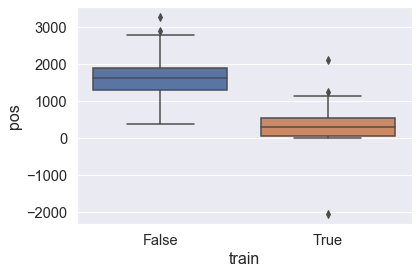

In [14]:
ax = sns.boxplot(x="train", y="pos", data=df_feat_kr)

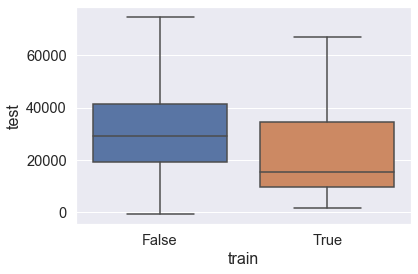

In [15]:
ax = sns.boxplot(x="train", y="test", data=df_feat_kr)

In [16]:
ax = sns.boxplot(x="train", y="age_pos", data=df_feat_kr)

In [17]:
ax = sns.boxplot(x="train", y="T_min", data=df_feat_kr)

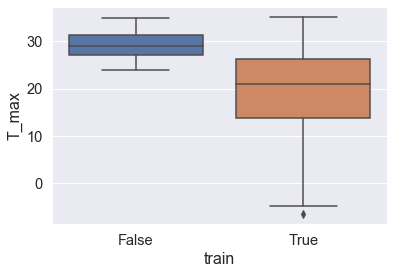

In [18]:
ax = sns.boxplot(x="train", y="T_max", data=df_feat_kr)

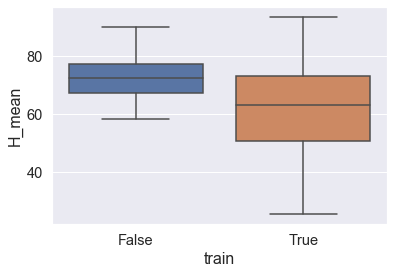

In [19]:
ax = sns.boxplot(x="train", y="H_mean", data=df_feat_kr)

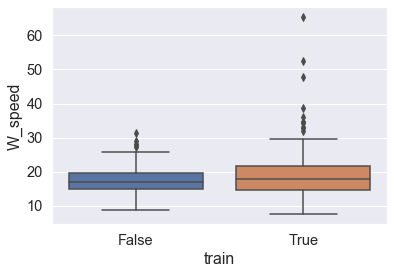

In [20]:
ax = sns.boxplot(x="train", y="W_speed", data=df_feat_kr)

#### Impact of features

In [21]:
df_tot = load_df_feat_kr()

In [22]:
ax = sns.boxplot(x="train", y="age_pos", data=df_feat_kr)

In [23]:
# data : nb pos / age_mean

# create vector ages 
plt.hist(df_tot["age_pos"], bins=np.arange(0,95, 2.5), 
         weights=df_tot["pos"], density=False);

In [24]:
list_col = ['pos_4.5', 'pos_14.5', 'pos_24.5', 'pos_34.5', 'pos_44.5',
       'pos_54.5', 'pos_64.5', 'pos_74.5', 'pos_85']
s_sum = df_tot[list_col].sum()
df_age = pd.DataFrame({'pos_age': list_col,
                   'pos': s_sum.values}, index=list_col)
def fun_extrac_age(str_in):
    re_found = re.search('(?<=pos_)[\d\.]+',str_in)
    return float(re_found[0])
df_age["age"] = df_age["pos_age"].apply(fun_extrac_age)
df_age



pos_age      pos   age
pos_4.5    pos_4.5  17148.0   4.5
pos_14.5  pos_14.5  27202.0  14.5
pos_24.5  pos_24.5  58287.0  24.5
pos_34.5  pos_34.5  49038.0  34.5
pos_44.5  pos_44.5  49473.0  44.5
pos_54.5  pos_54.5  49685.0  54.5
pos_64.5  pos_64.5  34179.0  64.5
pos_74.5  pos_74.5  13860.0  74.5
pos_85      pos_85   7362.0  85.0

In [25]:
plt.hist(df_age["age"], bins=np.arange(0,95, 10), 
         weights=df_age["pos"], density=False);

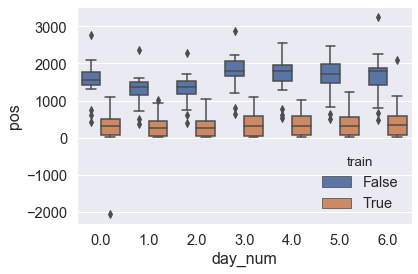

In [26]:
ax = sns.boxplot(x="day_num", y="pos", hue="train", data=df_feat_kr)

=> Hard to be confident for create a good model because train and test data are very different!

In [27]:
df_days = df_feat_kr.copy()
nb_days_week = 7

df_days['week_sin'] = np.sin(df_days["day_num"] * (2 * np.pi / nb_days_week))
df_days['week_cos'] = np.cos(df_days["day_num"] * (2 * np.pi / nb_days_week))

Text(0.5, 1.0, 'Time of week signal')

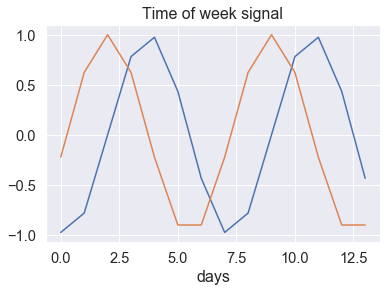

In [28]:
plt.plot(np.array(df_days['week_sin'])[:14])
plt.plot(np.array(df_days['week_cos'])[:14])
plt.xlabel('days')
plt.title('Time of week signal')

In [29]:
fft = tf.signal.rfft(df_days['pos'])
f_per_dataset = np.arange(0, len(fft))

In [30]:
df_days.shape

(549, 90)

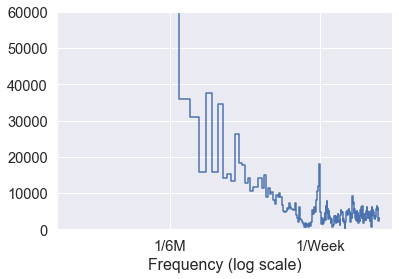

In [31]:
n_samples_day = len(df_days['pos'])
days_per_year = 365
years_per_dataset = n_samples_day/(days_per_year)
f_per_year = f_per_dataset/years_per_dataset

#nb_days_week
#weeks_per_dataset = n_samples_day/nb_days_week
#f_per_week = f_per_dataset/years_per_dataset

plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 60000)
plt.xlim([0.2, max(plt.xlim())])
plt.xticks([365/7, 365/(7*4*6)], labels=['1/Week', '1/6M'])
_ = plt.xlabel('Frequency (log scale)')

=> weekly periodicity

## Prepare features

In [32]:
dataset, data_std, data_mean = prepare_dataset_kr(df_feat_kr)
print(dataset)
print("data_mean : ", data_mean)
print("data_std : ", data_std)

[[-0.43842911 -0.03335956 -1.13417801 ... -0.54278014  0.99641704
  -0.36171153]
 [-0.43518827 -0.12215801 -1.30377381 ... -0.54175984  1.49462556
  -0.36171153]
 [-0.69121488 -0.47024795 -1.81069496 ... -0.78082929 -1.49462556
  -0.36171153]
 ...
 [ 0.62456746  0.96473507  0.87577718 ...  0.86612906  0.99641704
  -1.18460223]
 [ 0.74123781  0.97183894  0.69498385 ...  1.20850407  1.49462556
  -1.2093789 ]
 [ 0.67966179  0.50653504  1.55066115 ... -0.76125225 -1.49462556
  -1.2093789 ]]
data_mean :  [9.74274736e+00 1.91463977e+01 6.28461287e+01 1.83575408e+01
 2.47927954e+02 1.90186801e+04 3.00000000e+00 4.41442174e+01]
data_std :  [1.02853891e+01 9.38454775e+00 1.42888758e+01 6.26324047e+00
 3.18936079e+02 1.56816352e+04 2.00719168e+00 6.20951246e+00]


In [33]:
dataset.shape

(549, 8)

## Multi-step model

### Helper functions

In [34]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 4]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()
    
    
def calculate_grad_max(x_train_multi, multi_step_model):
    '''
    Calculate absolute maximum of model gradients over training
    '''
    grad_final = 0
    for i_seq in range(x_train_multi.shape[0]):
        seq = tf.Variable(x_train_multi[i_seq][np.newaxis,:,:], dtype=tf.float32)

        with tf.GradientTape() as tape:
            predictions = multi_step_model(seq)
    
        grads = tape.gradient(predictions, seq)

        grad_min = abs(tf.reduce_min(grads).numpy())
        grad_max = abs(tf.reduce_max(grads).numpy())

        grad_curr = grad_min if grad_min > grad_max else grad_max

        grad_final = grad_curr if grad_curr > grad_final else grad_final
    
    return grad_final  

### data 14D_to_7D

In [35]:
TRAIN_SPLIT

439

In [36]:
dataset.shape

(549, 8)

In [37]:
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 4], 
                                0, TRAIN_SPLIT, PAST_HISTORY,
                                FUTURE_TARGET, STEP, single_step=False)

x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 4],
                                TRAIN_SPLIT-PAST_HISTORY, None, PAST_HISTORY,
                                FUTURE_TARGET, STEP, single_step=False)

In [38]:
y_train_multi.shape

(425, 7)

In [39]:
print ('{} Single window of past history : {}'.format(x_train_multi.shape[0],
                                                      x_train_multi[0].shape))
print ('\n {} Target temperature to predict : {}'.format(y_train_multi.shape[0],
                                                        y_train_multi[0].shape))

425 Single window of past history : (14, 8)

 425 Target temperature to predict : (7,)


In [40]:
print(f"nb samples for training : {x_train_multi.shape[0]}")
print(f"nb samples for validation : {x_val_multi.shape[0]}")

nb samples for training : 425
nb samples for validation : 103


### Training

#### No Norm

In [41]:
BATCH_SIZE = x_train_multi.shape[0]
BATCH_SIZE_VAL = y_val_multi.shape[0]
BUFFER_SIZE = TRAIN_SPLIT
tf.random.set_seed(0)

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, 
                                                       y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE) \
    .batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE_VAL).repeat()

print("For Training : ")
print("BATCH_SIZE :", BATCH_SIZE)
print("BUFFER_SIZE :", BUFFER_SIZE)
print("\nFor validation : ")
print("BATCH_SIZE_VAL :", BATCH_SIZE_VAL)


For Training : 
BATCH_SIZE : 333
BUFFER_SIZE : 347

For validation : 
BATCH_SIZE_VAL : 188



 Run #0
Restoring model weights from the end of the best epoch.
Epoch 01070: early stopping
Run #0 : val_loss = 1.9715712070465088


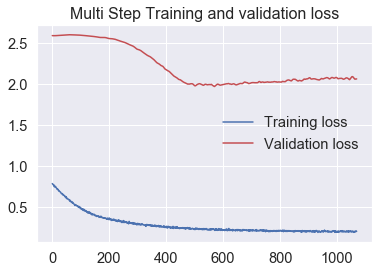

INFO:tensorflow:Assets written to: /Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/mdl_multi_step_pos_kr/assets


INFO:tensorflow:Assets written to: /Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/mdl_multi_step_pos_kr/assets



 Run #1
Restoring model weights from the end of the best epoch.
Epoch 02158: early stopping
Run #1 : val_loss = 1.0570120811462402


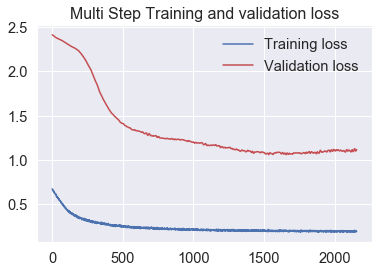

INFO:tensorflow:Assets written to: /Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/mdl_multi_step_pos_kr/assets


INFO:tensorflow:Assets written to: /Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/mdl_multi_step_pos_kr/assets



 Run #2
Restoring model weights from the end of the best epoch.
Epoch 02806: early stopping
Run #2 : val_loss = 1.912912368774414

 Run #3
Restoring model weights from the end of the best epoch.
Epoch 01773: early stopping
Run #3 : val_loss = 1.3512933254241943

 Run #4
Restoring model weights from the end of the best epoch.
Epoch 00958: early stopping
Run #4 : val_loss = 1.5433672666549683

 Run #5
Restoring model weights from the end of the best epoch.
Epoch 02651: early stopping
Run #5 : val_loss = 1.327536702156067

 Run #6
Restoring model weights from the end of the best epoch.
Epoch 01820: early stopping
Run #6 : val_loss = 1.2756412029266357

 Run #7
Restoring model weights from the end of the best epoch.
Epoch 01317: early stopping
Run #7 : val_loss = 1.716897964477539

 Run #8
Restoring model weights from the end of the best epoch.
Epoch 01306: early stopping
Run #8 : val_loss = 1.3580549955368042

 Run #9
Restoring model weights from the end of the best epoch.
Epoch 01150: e

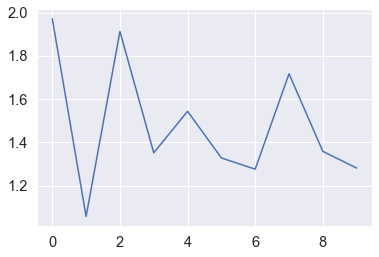

In [42]:
%%time
if mode_train:
    '''
    Run train (Batch Gradient Descent), NB_TRY times, over EPOCHS epochs 
    '''
    

    # Hyper-parameters
    
    # OLD : 
    # lr=2e-2: NB_TRY = 350 EPOCHS = 5000decay = 1e-6 #1e-6 momentum = 0.9  
    # nesterov = True  patience = 250
    #          Mean error  [nb of cases]:  100.51909796234426
    #          Mean nb cases  [nb of cases]:  996.6530612244898
    #          mean relative error [%]:  10.085665902520413
    # Wall time : 2h
    
    # NEW : 
    # Final val_loss = 0.2620798647403717
    # Mean error  [nb of cases]:  85.43251126273199
    # Mean nb cases  [nb of cases]:  648.3673469387755
    # mean relative error [%]:  13.17655981074557
    # Wall time: 4h 12min 6s (Mac)
    
    # No BatchNormalization, Adam, NB_TRY = 10, EPOCHS = 10000, patience = 500
    #Mean error  [nb of cases]:  88.7010976927777
    #Mean nb cases  [nb of cases]:  584.0803571428571
    #mean relative error [%]:  15.186454502027152
    #Wall time: 17min 26s
    # BatchNormalization, Adam, NB_TRY = 10, EPOCHS = 10000, patience = 500
    #Mean error  [nb of cases]:  87.9794333988124
    #Mean nb cases  [nb of cases]:  584.0803571428571
    #mean relative error [%]:  15.062898849942659
    # val_loss = 1.1182507276535034
    # Wall time: 12min 55s
    # Hyper-parameters
    NB_TRY = 10 #350
    EVALUATION_INTERVAL = 1
    EPOCHS = 10000 #5000
    #lr = 2e-2 #2e-2
    #decay = 1e-6 #1e-6
    #momentum = 0.9 # 0.9
    #nesterov = True # True
    patience = 500 # 250

    list_loss_multi = []

    for I in range(NB_TRY):
        print("")
        print(f" Run #{I}")

        tf.keras.backend.clear_session()
        # optimizer def 
        #optim = tf.keras.optimizers.SGD(lr=lr, decay=decay, momentum=momentum, 
        #                      nesterov=nesterov)
        optim = tf.optimizers.Adam()
        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                       verbose=1, patience=patience,
                                       restore_best_weights=True)
        # create model
        multi_step_model = tf.keras.models.Sequential()
        multi_step_model.add(tf.keras.layers.LSTM(x_train_multi.shape[-1], 
                                                  return_sequences=False,
                                            input_shape=x_train_multi.shape[-2:]))
        multi_step_model.add(tf.keras.layers.Dropout(0.2))
        #multi_step_model.add(tf.keras.layers.BatchNormalization())
        multi_step_model.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
        # compile
        multi_step_model.compile(optimizer=optim, loss='mae')
        # fitting
        multi_step_history = multi_step_model.fit(train_data_multi, 
                                                epochs=EPOCHS,
                                                steps_per_epoch=EVALUATION_INTERVAL,
                                                validation_data=val_data_multi,
                                                validation_steps=1,
                                                callbacks=[es],
                                                verbose=0)
        # eval
        mae_curr = np.min(multi_step_history.history['val_loss'])

        if (I == 0):
            list_loss_multi.append(mae_curr)

        # find the best model
        print(f"Run #{I} : val_loss = {mae_curr}")
        if (mae_curr < np.min(list_loss_multi)) | (I == 0):
            # plot history
            plot_train_history(multi_step_history,
                       'Multi Step Training and validation loss')
            # save
            if not(os.path.isdir(PATH_MDL_MULTI_STEP_KR)):
                os.mkdir(PATH_MDL_MULTI_STEP_KR)
            multi_step_model.save(PATH_MDL_MULTI_STEP_KR)

        if (I != 0):   
            list_loss_multi.append(mae_curr)

    print(" ")
    print(f"Final val_loss = {np.min(list_loss_multi)}")
    print("Mean asbolute Error in people :",
          data_std[4] * np.min(list_loss_multi))
    print(" ")
    plt.plot(list_loss_multi)


In [43]:
%%time
# reload best model
multi_step_model = tf.keras.models.load_model(PATH_MDL_MULTI_STEP_KR)

CPU times: user 2.34 s, sys: 80.4 ms, total: 2.42 s
Wall time: 2.6 s


In [44]:
y_train_multi_pred = multi_step_model.predict(x_train_multi)
mean_error_train = data_std[4] * mean_absolute_error(y_train_multi, 
                                                   y_train_multi_pred)
print("Train Mean Error  [nb of cases]: ", mean_error_train)
y_val_multi_pred = multi_step_model.predict(x_val_multi)
mean_error_val = data_std[4] * mean_absolute_error(y_val_multi, 
                                                   y_val_multi_pred)

print("Val. Mean Error  [nb of cases]: ", mean_error_val)
mean_val = np.mean(data_std[4] * y_val_multi + data_mean[4])
print("Val. Mean nb cases  [nb of cases]: ", mean_val)
print("Val. Mean Relative Error [%]: ", 100*mean_error_val/mean_val)

Train Mean Error  [nb of cases]:  47.089433737737075
Val. Mean Error  [nb of cases]:  337.11932409254825
Val. Mean nb cases  [nb of cases]:  1032.5615501519758
Val. Mean Relative Error [%]:  32.648835707946894


#### BatchNorm


 Run #0
Restoring model weights from the end of the best epoch.
Epoch 01727: early stopping
Run #0 : val_loss = 1.3120028972625732


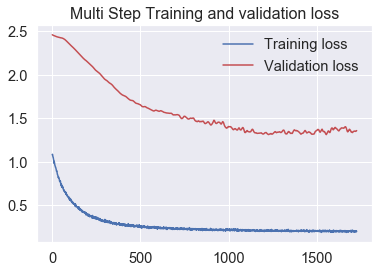

INFO:tensorflow:Assets written to: /Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/mdl_multi_step_pos_kr/assets


INFO:tensorflow:Assets written to: /Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/mdl_multi_step_pos_kr/assets



 Run #1
Restoring model weights from the end of the best epoch.
Epoch 01197: early stopping
Run #1 : val_loss = 1.5946844816207886

 Run #2
Restoring model weights from the end of the best epoch.
Epoch 01678: early stopping
Run #2 : val_loss = 1.5136677026748657

 Run #3
Restoring model weights from the end of the best epoch.
Epoch 04002: early stopping
Run #3 : val_loss = 1.4409089088439941

 Run #4
Restoring model weights from the end of the best epoch.
Epoch 01216: early stopping
Run #4 : val_loss = 1.9402395486831665

 Run #5
Restoring model weights from the end of the best epoch.
Epoch 02828: early stopping
Run #5 : val_loss = 1.2899905443191528


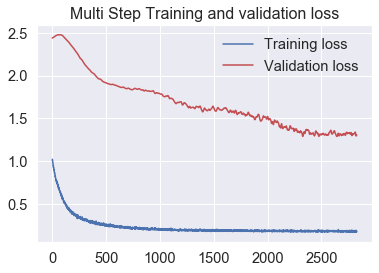

INFO:tensorflow:Assets written to: /Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/mdl_multi_step_pos_kr/assets


INFO:tensorflow:Assets written to: /Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/mdl_multi_step_pos_kr/assets



 Run #6
Restoring model weights from the end of the best epoch.
Epoch 01833: early stopping
Run #6 : val_loss = 1.9064172506332397

 Run #7
Restoring model weights from the end of the best epoch.
Epoch 01283: early stopping
Run #7 : val_loss = 1.4649568796157837

 Run #8
Restoring model weights from the end of the best epoch.
Epoch 02190: early stopping
Run #8 : val_loss = 1.3507956266403198

 Run #9
Restoring model weights from the end of the best epoch.
Epoch 00501: early stopping
Run #9 : val_loss = 2.6422204971313477
 
Final val_loss = 1.2899905443191528
Mean asbolute Error in people : 411.42452612627966
 
CPU times: user 8min 2s, sys: 1min 6s, total: 9min 9s
Wall time: 6min 30s


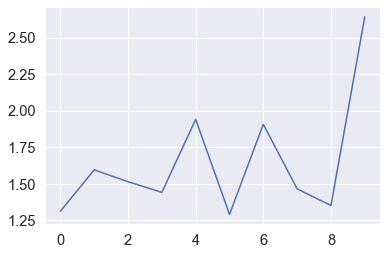

In [45]:
%%time
if mode_train:
    '''
    Run train (Batch Gradient Descent), NB_TRY times, over EPOCHS epochs 
    '''
    

    # Hyper-parameters
    
    # OLD : 
    # lr=2e-2: NB_TRY = 350 EPOCHS = 5000decay = 1e-6 #1e-6 momentum = 0.9  
    # nesterov = True  patience = 250
    #          Mean error  [nb of cases]:  100.51909796234426
    #          Mean nb cases  [nb of cases]:  996.6530612244898
    #          mean relative error [%]:  10.085665902520413
    # Wall time : 2h
    
    # NEW : 
    # Final val_loss = 0.2620798647403717
    # Mean error  [nb of cases]:  85.43251126273199
    # Mean nb cases  [nb of cases]:  648.3673469387755
    # mean relative error [%]:  13.17655981074557
    # Wall time: 4h 12min 6s (Mac)
    
    # No BatchNormalization, Adam, NB_TRY = 10, EPOCHS = 10000, patience = 500
    #Mean error  [nb of cases]:  88.7010976927777
    #Mean nb cases  [nb of cases]:  584.0803571428571
    #mean relative error [%]:  15.186454502027152
    #Wall time: 17min 26s
    # BatchNormalization, Adam, NB_TRY = 10, EPOCHS = 10000, patience = 500
    #Mean error  [nb of cases]:  87.9794333988124
    #Mean nb cases  [nb of cases]:  584.0803571428571
    #mean relative error [%]:  15.062898849942659
    # val_loss = 1.1182507276535034
    # Wall time: 12min 55s
    # Hyper-parameters
    NB_TRY = 10 #350
    EVALUATION_INTERVAL = 1
    EPOCHS = 10000 #5000
    #lr = 2e-2 #2e-2
    #decay = 1e-6 #1e-6
    #momentum = 0.9 # 0.9
    #nesterov = True # True
    patience = 500 # 250

    list_loss_multi = []

    for I in range(NB_TRY):
        print("")
        print(f" Run #{I}")

        tf.keras.backend.clear_session()
        # optimizer def 
        #optim = tf.keras.optimizers.SGD(lr=lr, decay=decay, momentum=momentum, 
        #                      nesterov=nesterov)
        optim = tf.optimizers.Adam()
        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                       verbose=1, patience=patience,
                                       restore_best_weights=True)
        # create model
        multi_step_model = tf.keras.models.Sequential()
        multi_step_model.add(tf.keras.layers.LSTM(x_train_multi.shape[-1], 
                                                  return_sequences=False,
                                            input_shape=x_train_multi.shape[-2:]))
        multi_step_model.add(tf.keras.layers.Dropout(0.2))
        multi_step_model.add(tf.keras.layers.BatchNormalization())
        multi_step_model.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
        # compile
        multi_step_model.compile(optimizer=optim, loss='mae')
        # fitting
        multi_step_history = multi_step_model.fit(train_data_multi, 
                                                epochs=EPOCHS,
                                                steps_per_epoch=EVALUATION_INTERVAL,
                                                validation_data=val_data_multi,
                                                validation_steps=1,
                                                callbacks=[es],
                                                verbose=0)
        # eval
        mae_curr = np.min(multi_step_history.history['val_loss'])

        if (I == 0):
            list_loss_multi.append(mae_curr)

        # find the best model
        print(f"Run #{I} : val_loss = {mae_curr}")
        if (mae_curr < np.min(list_loss_multi)) | (I == 0):
            # plot history
            plot_train_history(multi_step_history,
                       'Multi Step Training and validation loss')
            # save
            if not(os.path.isdir(PATH_MDL_MULTI_STEP_KR)):
                os.mkdir(PATH_MDL_MULTI_STEP_KR)
            multi_step_model.save(PATH_MDL_MULTI_STEP_KR)

        if (I != 0):   
            list_loss_multi.append(mae_curr)

    print(" ")
    print(f"Final val_loss = {np.min(list_loss_multi)}")
    print("Mean asbolute Error in people :",
          data_std[4] * np.min(list_loss_multi))
    print(" ")
    plt.plot(list_loss_multi)


In [46]:
%%time
# reload best model
multi_step_model = tf.keras.models.load_model(PATH_MDL_MULTI_STEP_KR)

CPU times: user 2.19 s, sys: 47.1 ms, total: 2.24 s
Wall time: 2.27 s


In [47]:
y_train_multi_pred = multi_step_model.predict(x_train_multi)
mean_error_train = data_std[4] * mean_absolute_error(y_train_multi, 
                                                   y_train_multi_pred)
print("Train Mean Error  [nb of cases]: ", mean_error_train)
y_val_multi_pred = multi_step_model.predict(x_val_multi)
mean_error_val = data_std[4] * mean_absolute_error(y_val_multi, 
                                                   y_val_multi_pred)

print("Val. Mean Error  [nb of cases]: ", mean_error_val)
mean_val = np.mean(data_std[4] * y_val_multi + data_mean[4])
print("Val. Mean nb cases  [nb of cases]: ", mean_val)
print("Val. Mean Relative Error [%]: ", 100*mean_error_val/mean_val)

Train Mean Error  [nb of cases]:  44.57762210086265
Val. Mean Error  [nb of cases]:  411.42449835088553
Val. Mean nb cases  [nb of cases]:  1032.5615501519758
Val. Mean Relative Error [%]:  39.845033769689636


#### LayerNorm


 Run #0
Restoring model weights from the end of the best epoch.
Epoch 01342: early stopping
Run #0 : val_loss = 1.4736167192459106


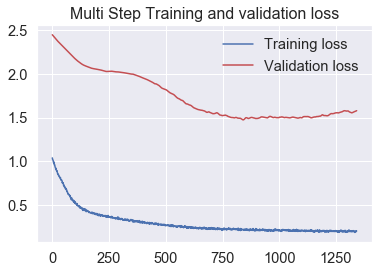

INFO:tensorflow:Assets written to: /Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/mdl_multi_step_pos_kr/assets


INFO:tensorflow:Assets written to: /Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/mdl_multi_step_pos_kr/assets



 Run #1
Restoring model weights from the end of the best epoch.
Epoch 02312: early stopping
Run #1 : val_loss = 2.2369611263275146

 Run #2
Restoring model weights from the end of the best epoch.
Epoch 02119: early stopping
Run #2 : val_loss = 1.556594967842102

 Run #3
Restoring model weights from the end of the best epoch.
Epoch 04206: early stopping
Run #3 : val_loss = 1.0066078901290894


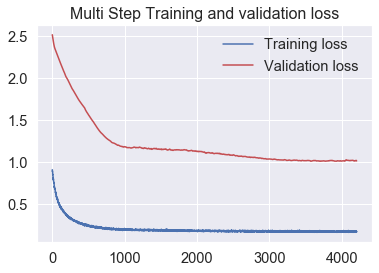

INFO:tensorflow:Assets written to: /Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/mdl_multi_step_pos_kr/assets


INFO:tensorflow:Assets written to: /Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/mdl_multi_step_pos_kr/assets



 Run #4
Restoring model weights from the end of the best epoch.
Epoch 02266: early stopping
Run #4 : val_loss = 1.116019606590271

 Run #5
Restoring model weights from the end of the best epoch.
Epoch 01777: early stopping
Run #5 : val_loss = 1.0842242240905762

 Run #6
Restoring model weights from the end of the best epoch.
Epoch 00958: early stopping
Run #6 : val_loss = 1.4705371856689453

 Run #7
Restoring model weights from the end of the best epoch.
Epoch 01325: early stopping
Run #7 : val_loss = 1.5736080408096313

 Run #8
Restoring model weights from the end of the best epoch.
Epoch 01318: early stopping
Run #8 : val_loss = 1.5793731212615967

 Run #9
Restoring model weights from the end of the best epoch.
Epoch 02518: early stopping
Run #9 : val_loss = 1.1613482236862183
 
Final val_loss = 1.0066078901290894
Mean asbolute Error in people : 321.04357354798776
 
CPU times: user 8min 55s, sys: 1min 13s, total: 10min 9s
Wall time: 7min 31s


In [48]:
%%time
if mode_train:
    '''
    Run train (Batch Gradient Descent), NB_TRY times, over EPOCHS epochs 
    '''
    

    # Hyper-parameters
    
    # OLD : 
    # lr=2e-2: NB_TRY = 350 EPOCHS = 5000decay = 1e-6 #1e-6 momentum = 0.9  
    # nesterov = True  patience = 250
    #          Mean error  [nb of cases]:  100.51909796234426
    #          Mean nb cases  [nb of cases]:  996.6530612244898
    #          mean relative error [%]:  10.085665902520413
    # Wall time : 2h
    
    # NEW : 
    # Final val_loss = 0.2620798647403717
    # Mean error  [nb of cases]:  85.43251126273199
    # Mean nb cases  [nb of cases]:  648.3673469387755
    # mean relative error [%]:  13.17655981074557
    # Wall time: 4h 12min 6s (Mac)
    
    # No BatchNormalization, Adam, NB_TRY = 10, EPOCHS = 10000, patience = 500
    #Mean error  [nb of cases]:  88.7010976927777
    #Mean nb cases  [nb of cases]:  584.0803571428571
    #mean relative error [%]:  15.186454502027152
    #Wall time: 17min 26s
    # BatchNormalization, Adam, NB_TRY = 10, EPOCHS = 10000, patience = 500
    #Mean error  [nb of cases]:  87.9794333988124
    #Mean nb cases  [nb of cases]:  584.0803571428571
    #mean relative error [%]:  15.062898849942659
    # val_loss = 1.1182507276535034
    # Wall time: 12min 55s
    # Hyper-parameters
    NB_TRY = 10 #350
    EVALUATION_INTERVAL = 1
    EPOCHS = 10000 #5000
    #lr = 2e-2 #2e-2
    #decay = 1e-6 #1e-6
    #momentum = 0.9 # 0.9
    #nesterov = True # True
    patience = 500 # 250

    list_loss_multi = []

    for I in range(NB_TRY):
        print("")
        print(f" Run #{I}")

        tf.keras.backend.clear_session()
        # optimizer def 
        #optim = tf.keras.optimizers.SGD(lr=lr, decay=decay, momentum=momentum, 
        #                      nesterov=nesterov)
        optim = tf.optimizers.Adam()
        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                       verbose=1, patience=patience,
                                       restore_best_weights=True)
        # create model
        multi_step_model = tf.keras.models.Sequential()
        multi_step_model.add(tf.keras.layers.LSTM(x_train_multi.shape[-1], 
                                                  return_sequences=False,
                                            input_shape=x_train_multi.shape[-2:]))
        multi_step_model.add(tf.keras.layers.Dropout(0.2))
        multi_step_model.add(tf.keras.layers.LayerNormalization())
        multi_step_model.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
        # compile
        multi_step_model.compile(optimizer=optim, loss='mae')
        # fitting
        multi_step_history = multi_step_model.fit(train_data_multi, 
                                                epochs=EPOCHS,
                                                steps_per_epoch=EVALUATION_INTERVAL,
                                                validation_data=val_data_multi,
                                                validation_steps=1,
                                                callbacks=[es],
                                                verbose=0)
        # eval
        mae_curr = np.min(multi_step_history.history['val_loss'])

        if (I == 0):
            list_loss_multi.append(mae_curr)

        # find the best model
        print(f"Run #{I} : val_loss = {mae_curr}")
        if (mae_curr < np.min(list_loss_multi)) | (I == 0):
            # plot history
            plot_train_history(multi_step_history,
                       'Multi Step Training and validation loss')
            # save
            if not(os.path.isdir(PATH_MDL_MULTI_STEP_KR)):
                os.mkdir(PATH_MDL_MULTI_STEP_KR)
            multi_step_model.save(PATH_MDL_MULTI_STEP_KR)

        if (I != 0):   
            list_loss_multi.append(mae_curr)

    print(" ")
    print(f"Final val_loss = {np.min(list_loss_multi)}")
    print("Mean asbolute Error in people :",
          data_std[4] * np.min(list_loss_multi))
    print(" ")
    plt.plot(list_loss_multi)


In [49]:
%%time
# reload best model
multi_step_model = tf.keras.models.load_model(PATH_MDL_MULTI_STEP_KR)

CPU times: user 2.04 s, sys: 41.9 ms, total: 2.08 s
Wall time: 2.27 s


In [50]:
y_train_multi_pred = multi_step_model.predict(x_train_multi)
mean_error_train = data_std[4] * mean_absolute_error(y_train_multi, 
                                                   y_train_multi_pred)
print("Train Mean Error  [nb of cases]: ", mean_error_train)
y_val_multi_pred = multi_step_model.predict(x_val_multi)
mean_error_val = data_std[4] * mean_absolute_error(y_val_multi, 
                                                   y_val_multi_pred)

print("Val. Mean Error  [nb of cases]: ", mean_error_val)
mean_val = np.mean(data_std[4] * y_val_multi + data_mean[4])
print("Val. Mean nb cases  [nb of cases]: ", mean_val)
print("Val. Mean Relative Error [%]: ", 100*mean_error_val/mean_val)

Train Mean Error  [nb of cases]:  48.17350218128274
Val. Mean Error  [nb of cases]:  321.0436128868625
Val. Mean nb cases  [nb of cases]:  1032.5615501519758
Val. Mean Relative Error [%]:  31.091958909336714


#### No Norm / mini-batch  : Batch=32

In [43]:
BATCH_SIZE = 32
BATCH_SIZE_VAL = y_val_multi.shape[0]
BUFFER_SIZE = x_train_multi.shape[0]
tf.random.set_seed(0)

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, 
                                                       y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE) \
    .batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE_VAL).repeat()

print("For Training : ")
print("BATCH_SIZE :", BATCH_SIZE)
print("BUFFER_SIZE :", BUFFER_SIZE)
print("\nFor validation : ")
print("BATCH_SIZE_VAL :", BATCH_SIZE_VAL)


For Training : 
BATCH_SIZE : 32
BUFFER_SIZE : 425

For validation : 
BATCH_SIZE_VAL : 103


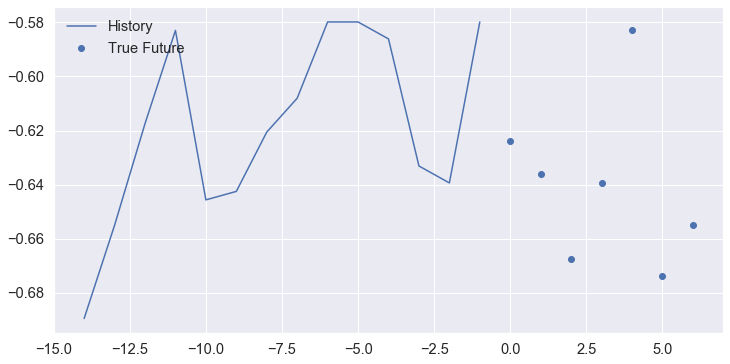

In [52]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))


 Run #0
Restoring model weights from the end of the best epoch.
Epoch 00855: early stopping
Run #0 : val_loss = 1.85639488697052


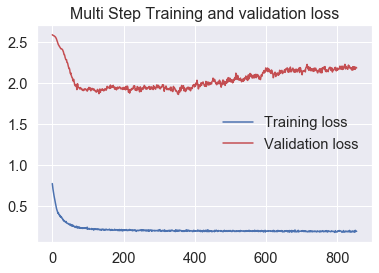

INFO:tensorflow:Assets written to: /Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/mdl_multi_step_pos_kr/assets


INFO:tensorflow:Assets written to: /Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/mdl_multi_step_pos_kr/assets



 Run #1
Restoring model weights from the end of the best epoch.
Epoch 00698: early stopping
Run #1 : val_loss = 1.14482581615448


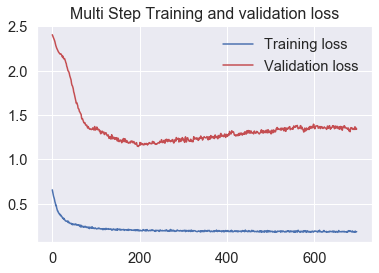

INFO:tensorflow:Assets written to: /Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/mdl_multi_step_pos_kr/assets


INFO:tensorflow:Assets written to: /Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/mdl_multi_step_pos_kr/assets



 Run #2
Restoring model weights from the end of the best epoch.
Epoch 02407: early stopping
Run #2 : val_loss = 1.1043412685394287


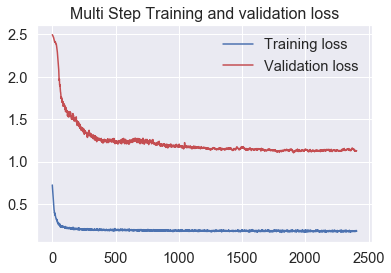

INFO:tensorflow:Assets written to: /Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/mdl_multi_step_pos_kr/assets


INFO:tensorflow:Assets written to: /Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/mdl_multi_step_pos_kr/assets



 Run #3
Restoring model weights from the end of the best epoch.
Epoch 00753: early stopping
Run #3 : val_loss = 1.1913533210754395

 Run #4
Restoring model weights from the end of the best epoch.
Epoch 00653: early stopping
Run #4 : val_loss = 1.1172319650650024

 Run #5
Restoring model weights from the end of the best epoch.
Epoch 02655: early stopping
Run #5 : val_loss = 1.1607738733291626

 Run #6
Restoring model weights from the end of the best epoch.
Epoch 00666: early stopping
Run #6 : val_loss = 1.13983154296875

 Run #7
Restoring model weights from the end of the best epoch.
Epoch 00627: early stopping
Run #7 : val_loss = 1.6652635335922241

 Run #8
Restoring model weights from the end of the best epoch.
Epoch 01338: early stopping
Run #8 : val_loss = 1.208046793937683

 Run #9
Restoring model weights from the end of the best epoch.
Epoch 01248: early stopping
Run #9 : val_loss = 1.0745255947113037


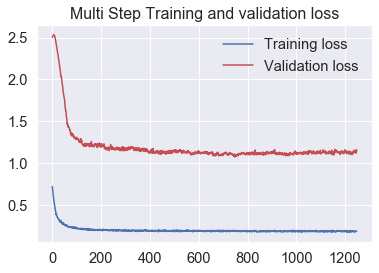

INFO:tensorflow:Assets written to: /Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/mdl_multi_step_pos_kr/assets


INFO:tensorflow:Assets written to: /Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/mdl_multi_step_pos_kr/assets


 
Final val_loss = 1.0745255947113037
Mean asbolute Error in people : 342.7049799407535
 
CPU times: user 21min 18s, sys: 3min 58s, total: 25min 17s
Wall time: 13min 5s


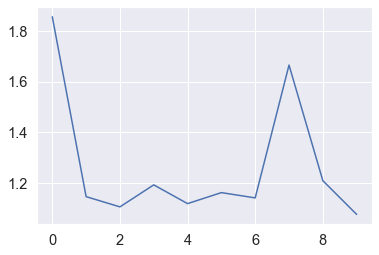

In [53]:
%%time
if mode_train:
    '''
    Run train (Batch Gradient Descent), NB_TRY times, over EPOCHS epochs 
    '''
    

    # Hyper-parameters
    
    # OLD : 
    # lr=2e-2: NB_TRY = 350 EPOCHS = 5000decay = 1e-6 #1e-6 momentum = 0.9  
    # nesterov = True  patience = 250
    #          Mean error  [nb of cases]:  100.51909796234426
    #          Mean nb cases  [nb of cases]:  996.6530612244898
    #          mean relative error [%]:  10.085665902520413
    # Wall time : 2h
    
    # NEW : 
    # Final val_loss = 0.2620798647403717
    # Mean error  [nb of cases]:  85.43251126273199
    # Mean nb cases  [nb of cases]:  648.3673469387755
    # mean relative error [%]:  13.17655981074557
    # Wall time: 4h 12min 6s (Mac)
    
    # No BatchNormalization, Adam, NB_TRY = 10, EPOCHS = 10000, patience = 500
    #Mean error  [nb of cases]:  88.7010976927777
    #Mean nb cases  [nb of cases]:  584.0803571428571
    #mean relative error [%]:  15.186454502027152
    #Wall time: 17min 26s
    # BatchNormalization, Adam, NB_TRY = 10, EPOCHS = 10000, patience = 500
    #Mean error  [nb of cases]:  87.9794333988124
    #Mean nb cases  [nb of cases]:  584.0803571428571
    #mean relative error [%]:  15.062898849942659
    # val_loss = 1.1182507276535034
    # Wall time: 12min 55s
    # Hyper-parameters
    NB_TRY = 10 #350
    STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)
    EPOCHS = 10000 #5000
    #lr = 2e-2 #2e-2
    #decay = 1e-6 #1e-6
    #momentum = 0.9 # 0.9
    #nesterov = True # True
    patience = 500 # 250

    list_loss_multi = []

    for I in range(NB_TRY):
        print("")
        print(f" Run #{I}")

        tf.keras.backend.clear_session()
        # optimizer def 
        #optim = tf.keras.optimizers.SGD(lr=lr, decay=decay, momentum=momentum, 
        #                      nesterov=nesterov)
        optim = tf.optimizers.Adam()
        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                       verbose=1, patience=patience,
                                       restore_best_weights=True)
        # create model
        multi_step_model = tf.keras.models.Sequential()
        multi_step_model.add(tf.keras.layers.LSTM(x_train_multi.shape[-1], 
                                                  return_sequences=False,
                                            input_shape=x_train_multi.shape[-2:]))
        multi_step_model.add(tf.keras.layers.Dropout(0.2))
        #multi_step_model.add(tf.keras.layers.LayerNormalization())
        multi_step_model.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
        # compile
        multi_step_model.compile(optimizer=optim, loss='mae')
        # fitting
        multi_step_history = multi_step_model.fit(train_data_multi, 
                                                epochs=EPOCHS,
                                                steps_per_epoch=STEPS_PER_EPOCH,
                                                validation_data=val_data_multi,
                                                validation_steps=1,
                                                callbacks=[es],
                                                verbose=0)
        # eval
        mae_curr = np.min(multi_step_history.history['val_loss'])

        if (I == 0):
            list_loss_multi.append(mae_curr)

        # find the best model
        print(f"Run #{I} : val_loss = {mae_curr}")
        if (mae_curr < np.min(list_loss_multi)) | (I == 0):
            # plot history
            plot_train_history(multi_step_history,
                       'Multi Step Training and validation loss')
            # save
            if not(os.path.isdir(PATH_MDL_MULTI_STEP_KR)):
                os.mkdir(PATH_MDL_MULTI_STEP_KR)
            multi_step_model.save(PATH_MDL_MULTI_STEP_KR)

        if (I != 0):   
            list_loss_multi.append(mae_curr)

    print(" ")
    print(f"Final val_loss = {np.min(list_loss_multi)}")
    print("Mean asbolute Error in people :",
          data_std[4] * np.min(list_loss_multi))
    print(" ")
    plt.plot(list_loss_multi)


In [54]:
%%time
# reload best model
multi_step_model = tf.keras.models.load_model(PATH_MDL_MULTI_STEP_KR)

CPU times: user 2.73 s, sys: 121 ms, total: 2.85 s
Wall time: 11.8 s


In [55]:
y_train_multi_pred = multi_step_model.predict(x_train_multi)
mean_error_train = data_std[4] * mean_absolute_error(y_train_multi, 
                                                   y_train_multi_pred)
print("Train Mean Error  [nb of cases]: ", mean_error_train)
y_val_multi_pred = multi_step_model.predict(x_val_multi)
mean_error_val = data_std[4] * mean_absolute_error(y_val_multi, 
                                                   y_val_multi_pred)

print("Val. Mean Error  [nb of cases]: ", mean_error_val)
mean_val = np.mean(data_std[4] * y_val_multi + data_mean[4])
print("Val. Mean nb cases  [nb of cases]: ", mean_val)
print("Val. Mean Relative Error [%]: ", 100*mean_error_val/mean_val)

Train Mean Error  [nb of cases]:  45.98088696476167
Val. Mean Error  [nb of cases]:  342.70495993676826
Val. Mean nb cases  [nb of cases]:  1032.5615501519758
Val. Mean Relative Error [%]:  33.18978514029772


#### Layer Norm / mini-batch  : Batch=32


 Run #0
Restoring model weights from the end of the best epoch.
Epoch 00691: early stopping
Run #0 : val_loss = 1.118997573852539


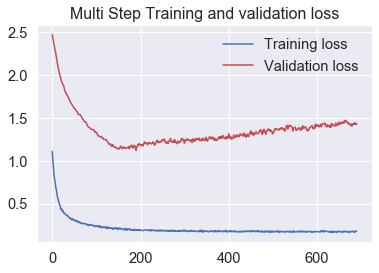

INFO:tensorflow:Assets written to: /Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/mdl_multi_step_pos_kr/assets


INFO:tensorflow:Assets written to: /Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/mdl_multi_step_pos_kr/assets



 Run #1
Restoring model weights from the end of the best epoch.
Epoch 00692: early stopping
Run #1 : val_loss = 1.1555095911026

 Run #2
Restoring model weights from the end of the best epoch.
Epoch 00758: early stopping
Run #2 : val_loss = 1.4308890104293823

 Run #3
Restoring model weights from the end of the best epoch.
Epoch 00718: early stopping
Run #3 : val_loss = 1.426993489265442

 Run #4
Restoring model weights from the end of the best epoch.
Epoch 01043: early stopping
Run #4 : val_loss = 1.2410945892333984

 Run #5
Restoring model weights from the end of the best epoch.
Epoch 01262: early stopping
Run #5 : val_loss = 1.0388749837875366


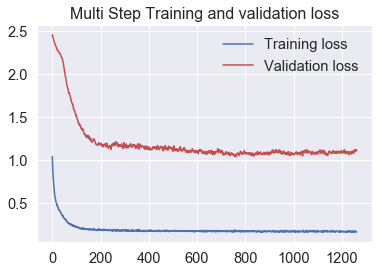

INFO:tensorflow:Assets written to: /Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/mdl_multi_step_pos_kr/assets


INFO:tensorflow:Assets written to: /Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/mdl_multi_step_pos_kr/assets



 Run #6
Restoring model weights from the end of the best epoch.
Epoch 00884: early stopping
Run #6 : val_loss = 1.0397722721099854

 Run #7
Restoring model weights from the end of the best epoch.
Epoch 01343: early stopping
Run #7 : val_loss = 1.2025378942489624

 Run #8
Restoring model weights from the end of the best epoch.
Epoch 01248: early stopping
Run #8 : val_loss = 1.0297722816467285


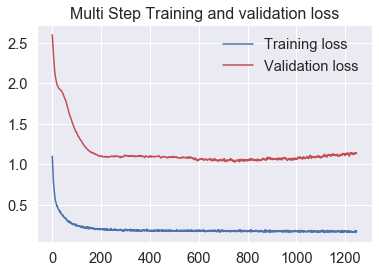

INFO:tensorflow:Assets written to: /Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/mdl_multi_step_pos_kr/assets


INFO:tensorflow:Assets written to: /Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/mdl_multi_step_pos_kr/assets



 Run #9
Restoring model weights from the end of the best epoch.
Epoch 00742: early stopping
Run #9 : val_loss = 1.8715007305145264
 
Final val_loss = 1.0297722816467285
Mean asbolute Error in people : 328.4315337505786
 
CPU times: user 16min 49s, sys: 2min 37s, total: 19min 27s
Wall time: 12min 55s


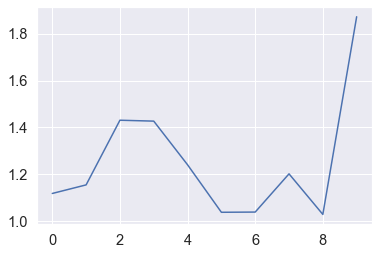

In [56]:
%%time
if mode_train:
    '''
    Run train (Batch Gradient Descent), NB_TRY times, over EPOCHS epochs 
    '''
    # Hyper-parameters
    NB_TRY = 10
    STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)
    EPOCHS = 10000 
    patience = 500 

    list_loss_multi = []

    for I in range(NB_TRY):
        print("")
        print(f" Run #{I}")

        tf.keras.backend.clear_session()
        optim = tf.optimizers.Adam()
        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                       verbose=1, patience=patience,
                                       restore_best_weights=True)
        # create model
        multi_step_model = tf.keras.models.Sequential()
        multi_step_model.add(tf.keras.layers.LSTM(x_train_multi.shape[-1], 
                                        return_sequences=False,
                                        input_shape=x_train_multi.shape[-2:]))
        multi_step_model.add(tf.keras.layers.Dropout(0.2))
        multi_step_model.add(tf.keras.layers.LayerNormalization())
        multi_step_model.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
        # compile
        multi_step_model.compile(optimizer=optim, loss='mae')
        # fitting
        multi_step_history = multi_step_model.fit(train_data_multi, 
                                                epochs=EPOCHS,
                                                steps_per_epoch=STEPS_PER_EPOCH,
                                                validation_data=val_data_multi,
                                                validation_steps=1,
                                                callbacks=[es],
                                                verbose=0)
        # eval
        mae_curr = np.min(multi_step_history.history['val_loss'])

        if (I == 0):
            list_loss_multi.append(mae_curr)

        # find the best model
        print(f"Run #{I} : val_loss = {mae_curr}")
        if (mae_curr < np.min(list_loss_multi)) | (I == 0):
            # plot history
            plot_train_history(multi_step_history,
                       'Multi Step Training and validation loss')
            # save
            if not(os.path.isdir(PATH_MDL_MULTI_STEP_KR)):
                os.mkdir(PATH_MDL_MULTI_STEP_KR)
            multi_step_model.save(PATH_MDL_MULTI_STEP_KR)

        if (I != 0):   
            list_loss_multi.append(mae_curr)

    print(" ")
    print(f"Final val_loss = {np.min(list_loss_multi)}")
    print("Mean asbolute Error in people :",
          data_std[4] * np.min(list_loss_multi))
    print(" ")
    plt.plot(list_loss_multi)


In [57]:
%%time
# reload best model
multi_step_model = tf.keras.models.load_model(PATH_MDL_MULTI_STEP_KR)

CPU times: user 2.03 s, sys: 91.2 ms, total: 2.12 s
Wall time: 2.21 s


In [58]:
y_train_multi_pred = multi_step_model.predict(x_train_multi)
mean_error_train = data_std[4] * mean_absolute_error(y_train_multi, 
                                                   y_train_multi_pred)
print("Train Mean Error  [nb of cases]: ", mean_error_train)
y_val_multi_pred = multi_step_model.predict(x_val_multi)
mean_error_val = data_std[4] * mean_absolute_error(y_val_multi, 
                                                   y_val_multi_pred)

print("Val. Mean Error  [nb of cases]: ", mean_error_val)
mean_val = np.mean(data_std[4] * y_val_multi + data_mean[4])
print("Val. Mean nb cases  [nb of cases]: ", mean_val)
print("Val. Mean Relative Error [%]: ", 100*mean_error_val/mean_val)

Train Mean Error  [nb of cases]:  51.4388333015783
Val. Mean Error  [nb of cases]:  328.43153692449
Val. Mean nb cases  [nb of cases]:  1032.5615501519758
Val. Mean Relative Error [%]:  31.807453693791945


#### Layer Norm / mini-batch 32 / drop 0.1


 Run #0
Restoring model weights from the end of the best epoch.
Epoch 00668: early stopping
Run #0 : val_loss = 1.4098161458969116


INFO:tensorflow:Assets written to: /Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/mdl_multi_step_pos_kr/assets


INFO:tensorflow:Assets written to: /Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/mdl_multi_step_pos_kr/assets



 Run #1
Restoring model weights from the end of the best epoch.
Epoch 01011: early stopping
Run #1 : val_loss = 1.520681381225586

 Run #2
Restoring model weights from the end of the best epoch.
Epoch 00900: early stopping
Run #2 : val_loss = 1.4196735620498657
 
Final val_loss = 1.4098161458969116
Mean asbolute Error in people : 449.6412336548961
 
CPU times: user 4min 46s, sys: 36.2 s, total: 5min 22s
Wall time: 5min 25s


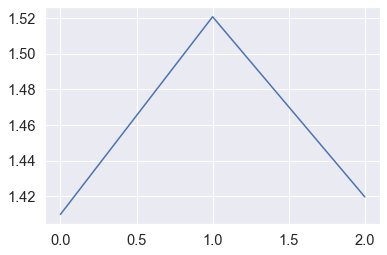

In [59]:
%%time
if mode_train:
    '''
    Run train (Batch Gradient Descent), NB_TRY times, over EPOCHS epochs 
    '''
    # Hyper-parameters
    NB_TRY = 3
    STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)
    EPOCHS = 10000 
    patience = 500 
    dropout_rate = 0.1
    list_loss_multi = []

    for I in range(NB_TRY):
        print("")
        print(f" Run #{I}")

        tf.keras.backend.clear_session()
        optim = tf.optimizers.Adam()
        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                       verbose=1, patience=patience,
                                       restore_best_weights=True)
        # create model
        multi_step_model = tf.keras.models.Sequential()
        multi_step_model.add(tf.keras.layers.LSTM(x_train_multi.shape[-1], 
                                        return_sequences=False,
                                        input_shape=x_train_multi.shape[-2:]))
        multi_step_model.add(tf.keras.layers.Dropout(dropout_rate))
        multi_step_model.add(tf.keras.layers.LayerNormalization())
        multi_step_model.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
        # compile
        multi_step_model.compile(optimizer=optim, loss='mae')
        # fitting
        multi_step_history = multi_step_model.fit(train_data_multi, 
                                                epochs=EPOCHS,
                                                steps_per_epoch=STEPS_PER_EPOCH,
                                                validation_data=val_data_multi,
                                                validation_steps=1,
                                                callbacks=[es],
                                                verbose=0)
        # eval
        mae_curr = np.min(multi_step_history.history['val_loss'])

        if (I == 0):
            list_loss_multi.append(mae_curr)

        # find the best model
        print(f"Run #{I} : val_loss = {mae_curr}")
        if (mae_curr < np.min(list_loss_multi)) | (I == 0):
            # plot history
            plot_train_history(multi_step_history,
                       'Multi Step Training and validation loss')
            # save
            if not(os.path.isdir(PATH_MDL_MULTI_STEP_KR)):
                os.mkdir(PATH_MDL_MULTI_STEP_KR)
            multi_step_model.save(PATH_MDL_MULTI_STEP_KR)

        if (I != 0):   
            list_loss_multi.append(mae_curr)

    print(" ")
    print(f"Final val_loss = {np.min(list_loss_multi)}")
    print("Mean asbolute Error in people :",
          data_std[4] * np.min(list_loss_multi))
    print(" ")
    plt.plot(list_loss_multi)


In [60]:
dropout_rate

0.1

In [61]:
%%time
# reload best model
multi_step_model = tf.keras.models.load_model(PATH_MDL_MULTI_STEP_KR)

CPU times: user 2.7 s, sys: 587 ms, total: 3.28 s
Wall time: 3.95 s


In [62]:
y_train_multi_pred = multi_step_model.predict(x_train_multi)
mean_error_train = data_std[4] * mean_absolute_error(y_train_multi, 
                                                   y_train_multi_pred)
print("Train Mean Error  [nb of cases]: ", mean_error_train)
y_val_multi_pred = multi_step_model.predict(x_val_multi)
mean_error_val = data_std[4] * mean_absolute_error(y_val_multi, 
                                                   y_val_multi_pred)

print("Val. Mean Error  [nb of cases]: ", mean_error_val)
mean_val = np.mean(data_std[4] * y_val_multi + data_mean[4])
print("Val. Mean nb cases  [nb of cases]: ", mean_val)
print("Val. Mean Relative Error [%]: ", 100*mean_error_val/mean_val)

Train Mean Error  [nb of cases]:  50.060715359533944
Val. Mean Error  [nb of cases]:  449.64123661484695
Val. Mean nb cases  [nb of cases]:  1032.5615501519758
Val. Mean Relative Error [%]:  43.546192142121434


In [63]:
x_train_multi.shape

(333, 14, 8)

In [64]:
x_train_multi[0].shape

(14, 8)

#### Evaluation Gradient max : 

In [88]:
calculate_grad_max(x_train_multi, multi_step_model)

4.793269

#### Layer Norm / mini-batch 32 / drop 0.2 / gradient clip 2.85


 Run #0
Restoring model weights from the end of the best epoch.
Epoch 00943: early stopping
Run #0 : val_loss = 1.06229567527771


INFO:tensorflow:Assets written to: /Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/mdl_multi_step_pos_kr/assets


INFO:tensorflow:Assets written to: /Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/mdl_multi_step_pos_kr/assets



 Run #1
Restoring model weights from the end of the best epoch.
Epoch 00816: early stopping
Run #1 : val_loss = 1.0359408855438232


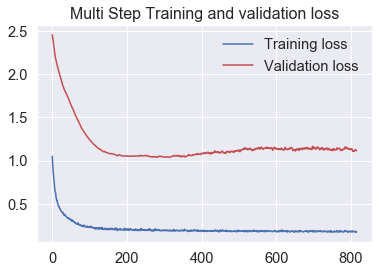

INFO:tensorflow:Assets written to: /Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/mdl_multi_step_pos_kr/assets


INFO:tensorflow:Assets written to: /Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/mdl_multi_step_pos_kr/assets



 Run #2
Restoring model weights from the end of the best epoch.
Epoch 00645: early stopping
Run #2 : val_loss = 1.3231922388076782
 
Final val_loss = 1.0359408855438232
Mean asbolute Error in people : 330.398924090298
 
CPU times: user 4min 39s, sys: 35.3 s, total: 5min 14s
Wall time: 5min 2s


In [66]:
%%time
if mode_train:
    '''
    Run train (Batch Gradient Descent), NB_TRY times, over EPOCHS epochs 
    '''
    # Hyper-parameters
    NB_TRY = 3
    STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)
    EPOCHS = 10000 
    patience = 500 
    dropout_rate = 0.2
    clipvalue = 2.85
    list_loss_multi = []

    for I in range(NB_TRY):
        print("")
        print(f" Run #{I}")

        tf.keras.backend.clear_session()
        optim = tf.optimizers.Adam(clipvalue=clipvalue)
        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                       verbose=1, patience=patience,
                                       restore_best_weights=True)
        # create model
        multi_step_model = tf.keras.models.Sequential()
        multi_step_model.add(tf.keras.layers.LSTM(x_train_multi.shape[-1], 
                                        return_sequences=False,
                                        input_shape=x_train_multi.shape[-2:]))
        multi_step_model.add(tf.keras.layers.Dropout(dropout_rate))
        multi_step_model.add(tf.keras.layers.LayerNormalization())
        multi_step_model.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
        # compile
        multi_step_model.compile(optimizer=optim, loss='mae')
        # fitting
        multi_step_history = multi_step_model.fit(train_data_multi, 
                                                epochs=EPOCHS,
                                                steps_per_epoch=STEPS_PER_EPOCH,
                                                validation_data=val_data_multi,
                                                validation_steps=1,
                                                callbacks=[es],
                                                verbose=0)
        # eval
        mae_curr = np.min(multi_step_history.history['val_loss'])

        if (I == 0):
            list_loss_multi.append(mae_curr)

        # find the best model
        print(f"Run #{I} : val_loss = {mae_curr}")
        if (mae_curr < np.min(list_loss_multi)) | (I == 0):
            # plot history
            plot_train_history(multi_step_history,
                       'Multi Step Training and validation loss')
            # save
            if not(os.path.isdir(PATH_MDL_MULTI_STEP_KR)):
                os.mkdir(PATH_MDL_MULTI_STEP_KR)
            multi_step_model.save(PATH_MDL_MULTI_STEP_KR)

        if (I != 0):   
            list_loss_multi.append(mae_curr)

    print(" ")
    print(f"Final val_loss = {np.min(list_loss_multi)}")
    print("Mean asbolute Error in people :",
          data_std[4] * np.min(list_loss_multi))
    print(" ")
    plt.plot(list_loss_multi)


In [67]:
dropout_rate

0.2

In [68]:
%%time
# reload best model
multi_step_model = tf.keras.models.load_model(PATH_MDL_MULTI_STEP_KR)

CPU times: user 2.68 s, sys: 305 ms, total: 2.99 s
Wall time: 3.83 s


In [69]:
y_train_multi_pred = multi_step_model.predict(x_train_multi)
mean_error_train = data_std[4] * mean_absolute_error(y_train_multi, 
                                                   y_train_multi_pred)
print("Train Mean Error  [nb of cases]: ", mean_error_train)
y_val_multi_pred = multi_step_model.predict(x_val_multi)
mean_error_val = data_std[4] * mean_absolute_error(y_val_multi, 
                                                   y_val_multi_pred)

print("Val. Mean Error  [nb of cases]: ", mean_error_val)
mean_val = np.mean(data_std[4] * y_val_multi + data_mean[4])
print("Val. Mean nb cases  [nb of cases]: ", mean_val)
print("Val. Mean Relative Error [%]: ", 100*mean_error_val/mean_val)

Train Mean Error  [nb of cases]:  53.16293733720666
Val. Mean Error  [nb of cases]:  330.39891780028745
Val. Mean nb cases  [nb of cases]:  1032.5615501519758
Val. Mean Relative Error [%]:  31.99798769881159


#### Layer Norm / mini-batch 32 / drop recurrent 0.2 / gradient clip 2.85


 Run #0
Restoring model weights from the end of the best epoch.
Epoch 00504: early stopping
Run #0 : val_loss = 1.1644495725631714


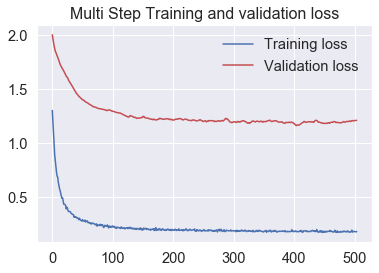

INFO:tensorflow:Assets written to: /Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/mdl_multi_step_pos_kr/assets


INFO:tensorflow:Assets written to: /Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/mdl_multi_step_pos_kr/assets



 Run #1
Restoring model weights from the end of the best epoch.
Epoch 00484: early stopping
Run #1 : val_loss = 0.9838086366653442


INFO:tensorflow:Assets written to: /Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/mdl_multi_step_pos_kr/assets


INFO:tensorflow:Assets written to: /Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/mdl_multi_step_pos_kr/assets



 Run #2
Restoring model weights from the end of the best epoch.
Epoch 00250: early stopping
Run #2 : val_loss = 1.1684362888336182
 
Final val_loss = 0.9838086366653442
Mean asbolute Error in people : 313.77206904459234
 
CPU times: user 4min 56s, sys: 1min 17s, total: 6min 13s
Wall time: 2min 50s


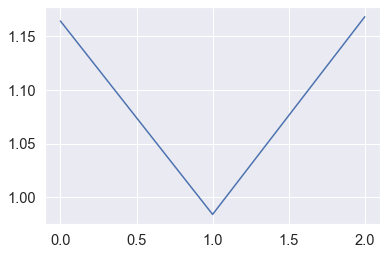

In [119]:
%%time
if mode_train:
    '''
    Run train (Batch Gradient Descent), NB_TRY times, over EPOCHS epochs 
    '''
    # Hyper-parameters
    NB_TRY = 3
    STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)
    EPOCHS = 1000
    patience = 100 
    dropout_rate = 0.2
    dropout_recurrent_rate = 0.2
    clipvalue = 2.85
    list_loss_multi = []

    for I in range(NB_TRY):
        print("")
        print(f" Run #{I}")

        tf.keras.backend.clear_session()
        optim = tf.optimizers.Adam(clipvalue=clipvalue)
        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                       verbose=1, patience=patience,
                                       restore_best_weights=True)
        # create model
        multi_step_model = tf.keras.models.Sequential()
        multi_step_model.add(tf.keras.layers.LSTM(x_train_multi.shape[-1], 
                                    return_sequences=False,
                                    recurrent_dropout=dropout_recurrent_rate,
                                        input_shape=x_train_multi.shape[-2:]))
        multi_step_model.add(tf.keras.layers.Dropout(dropout_rate))
        multi_step_model.add(tf.keras.layers.LayerNormalization())
        multi_step_model.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
        # compile
        multi_step_model.compile(optimizer=optim, loss='mae')
        # fitting
        multi_step_history = multi_step_model.fit(train_data_multi, 
                                                epochs=EPOCHS,
                                                steps_per_epoch=STEPS_PER_EPOCH,
                                                validation_data=val_data_multi,
                                                validation_steps=1,
                                                callbacks=[es],
                                                verbose=0)
        # eval
        mae_curr = np.min(multi_step_history.history['val_loss'])

        if (I == 0):
            list_loss_multi.append(mae_curr)

        # find the best model
        print(f"Run #{I} : val_loss = {mae_curr}")
        if (mae_curr < np.min(list_loss_multi)) | (I == 0):
            # plot history
            plot_train_history(multi_step_history,
                       'Multi Step Training and validation loss')
            # save
            if not(os.path.isdir(PATH_MDL_MULTI_STEP_KR)):
                os.mkdir(PATH_MDL_MULTI_STEP_KR)
            multi_step_model.save(PATH_MDL_MULTI_STEP_KR)

        if (I != 0):   
            list_loss_multi.append(mae_curr)

    print(" ")
    print(f"Final val_loss = {np.min(list_loss_multi)}")
    print("Mean asbolute Error in people :",
          data_std[4] * np.min(list_loss_multi))
    print(" ")
    plt.plot(list_loss_multi)


In [120]:
dropout_rate

0.2

In [121]:
dropout_recurrent_rate

0.2

In [122]:
%%time
# reload best model
multi_step_model = tf.keras.models.load_model(PATH_MDL_MULTI_STEP_KR)

CPU times: user 1.38 s, sys: 40.8 ms, total: 1.42 s
Wall time: 1.63 s


In [123]:
y_train_multi_pred = multi_step_model.predict(x_train_multi)
mean_error_train = data_std[4] * mean_absolute_error(y_train_multi, 
                                                   y_train_multi_pred)
print("Train Mean Error  [nb of cases]: ", mean_error_train)
y_val_multi_pred = multi_step_model.predict(x_val_multi)
mean_error_val = data_std[4] * mean_absolute_error(y_val_multi, 
                                                   y_val_multi_pred)

print("Val. Mean Error  [nb of cases]: ", mean_error_val)
mean_val = np.mean(data_std[4] * y_val_multi + data_mean[4])
print("Val. Mean nb cases  [nb of cases]: ", mean_val)
print("Val. Mean Relative Error [%]: ", 100*mean_error_val/mean_val)

Train Mean Error  [nb of cases]:  53.84378298915986
Val. Mean Error  [nb of cases]:  313.77205579730855
Val. Mean nb cases  [nb of cases]:  1032.5615501519758
Val. Mean Relative Error [%]:  30.387733859654816


#### Layer Norm / mini-batch 32 / drop recurrent 0.4 / gradient clip 5


 Run #0
Restoring model weights from the end of the best epoch.
Epoch 00331: early stopping
Run #0 : val_loss = 8.755126953125


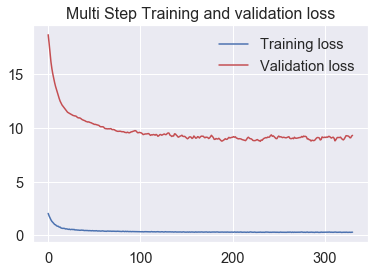

INFO:tensorflow:Assets written to: /Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/mdl_multi_step_pos_kr/assets

 Run #1
Restoring model weights from the end of the best epoch.
Epoch 00175: early stopping
Run #1 : val_loss = 9.112261772155762

 Run #2
Restoring model weights from the end of the best epoch.
Epoch 00296: early stopping
Run #2 : val_loss = 7.945974826812744


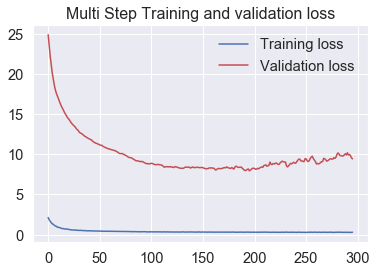

INFO:tensorflow:Assets written to: /Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/mdl_multi_step_pos_kr/assets

 Run #3
Restoring model weights from the end of the best epoch.
Epoch 00311: early stopping
Run #3 : val_loss = 10.438905715942383

 Run #4
Restoring model weights from the end of the best epoch.
Epoch 00211: early stopping
Run #4 : val_loss = 10.707469940185547

 Run #5
Restoring model weights from the end of the best epoch.
Epoch 00249: early stopping
Run #5 : val_loss = 7.96520471572876

 Run #6
Restoring model weights from the end of the best epoch.
Epoch 00264: early stopping
Run #6 : val_loss = 8.249593734741211

 Run #7
Restoring model weights from the end of the best epoch.
Epoch 00597: early stopping
Run #7 : val_loss = 8.35642147064209

 Run #8
Restoring model weights from the end of the best epoch.
Epoch 00274: early stopping
Run #8 : val_loss = 8.483636856079102

 Run #9
Restoring model weights from the end of th

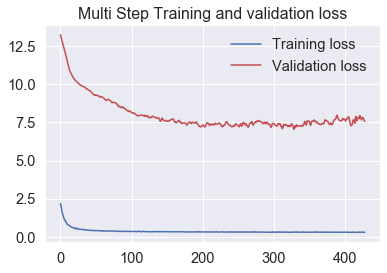

INFO:tensorflow:Assets written to: /Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/mdl_multi_step_pos_kr/assets

 Run #14
Restoring model weights from the end of the best epoch.
Epoch 00281: early stopping
Run #14 : val_loss = 7.975869178771973

 Run #15
Restoring model weights from the end of the best epoch.
Epoch 00276: early stopping
Run #15 : val_loss = 8.90286922454834

 Run #16
Restoring model weights from the end of the best epoch.
Epoch 00237: early stopping
Run #16 : val_loss = 10.91639232635498

 Run #17
Restoring model weights from the end of the best epoch.
Epoch 00168: early stopping
Run #17 : val_loss = 9.302967071533203

 Run #18
Restoring model weights from the end of the best epoch.
Epoch 00416: early stopping
Run #18 : val_loss = 8.474226951599121

 Run #19
Restoring model weights from the end of the best epoch.
Epoch 00375: early stopping
Run #19 : val_loss = 8.463704109191895

 Run #20
Restoring model weights from t

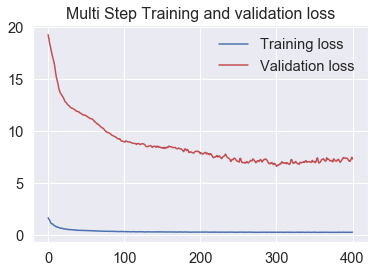

INFO:tensorflow:Assets written to: /Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/mdl_multi_step_pos_kr/assets

 Run #26
Restoring model weights from the end of the best epoch.
Epoch 00291: early stopping
Run #26 : val_loss = 7.494002342224121

 Run #27
Restoring model weights from the end of the best epoch.
Epoch 00405: early stopping
Run #27 : val_loss = 8.556378364562988

 Run #28
Restoring model weights from the end of the best epoch.
Epoch 00383: early stopping
Run #28 : val_loss = 7.451828479766846

 Run #29
Restoring model weights from the end of the best epoch.
Epoch 00348: early stopping
Run #29 : val_loss = 7.337862968444824

 Run #30
Restoring model weights from the end of the best epoch.
Epoch 00225: early stopping
Run #30 : val_loss = 8.916259765625

 Run #31
Restoring model weights from the end of the best epoch.
Epoch 00286: early stopping
Run #31 : val_loss = 9.178035736083984

 Run #32
Restoring model weights from the

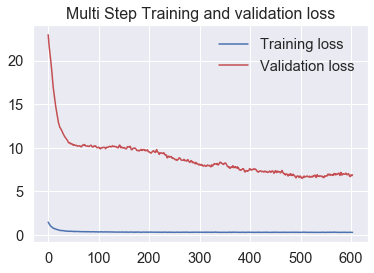

INFO:tensorflow:Assets written to: /Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/mdl_multi_step_pos_kr/assets

 Run #40
Restoring model weights from the end of the best epoch.
Epoch 00164: early stopping
Run #40 : val_loss = 10.9667329788208

 Run #41
Restoring model weights from the end of the best epoch.
Epoch 00363: early stopping
Run #41 : val_loss = 6.84415340423584

 Run #42
Restoring model weights from the end of the best epoch.
Epoch 00230: early stopping
Run #42 : val_loss = 9.861092567443848

 Run #43
Restoring model weights from the end of the best epoch.
Epoch 00201: early stopping
Run #43 : val_loss = 12.6337251663208

 Run #44
Restoring model weights from the end of the best epoch.
Epoch 00258: early stopping
Run #44 : val_loss = 9.017379760742188

 Run #45
Restoring model weights from the end of the best epoch.
Epoch 00287: early stopping
Run #45 : val_loss = 8.222532272338867

 Run #46
Restoring model weights from the

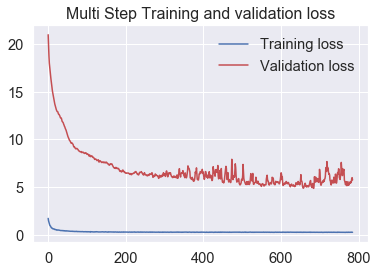

INFO:tensorflow:Assets written to: /Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/mdl_multi_step_pos_kr/assets

 Run #48
Restoring model weights from the end of the best epoch.
Epoch 00494: early stopping
Run #48 : val_loss = 9.747723579406738

 Run #49
Restoring model weights from the end of the best epoch.
Epoch 00255: early stopping
Run #49 : val_loss = 8.434181213378906
 
Final val_loss = 4.877290725708008
Mean asbolute Error in people : 1555.5439801022753
 
CPU times: user 1h 12min 23s, sys: 20min 28s, total: 1h 32min 52s
Wall time: 36min 19s


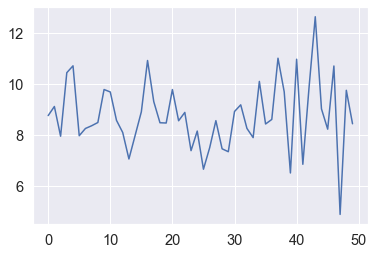

In [177]:
%%time
# Train Mean Error  [nb of cases]:  79.68283553387589
#Val. Mean Error  [nb of cases]:  77.00942832890918
#Val. Mean nb cases  [nb of cases]:  584.0803571428571
#Val. Mean Relative Error [%]:  13.184731756023401
if mode_train:
    '''
    Run train (Batch Gradient Descent), NB_TRY times, over EPOCHS epochs 
    '''
    # Hyper-parameters
    NB_TRY = 50
    STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)
    EPOCHS = 1000
    patience = 100 
    dropout_rate = 0.4
    dropout_recurrent_rate = 0.4
    clipvalue = 5
    list_loss_multi = []

    for I in range(NB_TRY):
        print("")
        print(f" Run #{I}")

        tf.keras.backend.clear_session()
        optim = tf.optimizers.Adam(clipvalue=clipvalue)
        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='mae', 
                                       verbose=1, patience=patience,
                                       restore_best_weights=True)
        # create model
        multi_step_model = tf.keras.models.Sequential()
        multi_step_model.add(tf.keras.layers.LSTM(x_train_multi.shape[-1], 
                                    return_sequences=False,
                                    recurrent_dropout=dropout_recurrent_rate,
                                        input_shape=x_train_multi.shape[-2:]))
        multi_step_model.add(tf.keras.layers.Dropout(dropout_rate))
        multi_step_model.add(tf.keras.layers.LayerNormalization())
        multi_step_model.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
        # compile
        multi_step_model.compile(optimizer=optim, loss='mse')
        # fitting
        multi_step_history = multi_step_model.fit(train_data_multi, 
                                                epochs=EPOCHS,
                                                steps_per_epoch=STEPS_PER_EPOCH,
                                                validation_data=val_data_multi,
                                                validation_steps=1,
                                                callbacks=[es],
                                                verbose=0)
        # eval
        mae_curr = np.min(multi_step_history.history['val_loss'])

        if (I == 0):
            list_loss_multi.append(mae_curr)

        # find the best model
        print(f"Run #{I} : val_loss = {mae_curr}")
        if (mae_curr < np.min(list_loss_multi)) | (I == 0):
            # plot history
            plot_train_history(multi_step_history,
                       'Multi Step Training and validation loss')
            # save
            if not(os.path.isdir(PATH_MDL_MULTI_STEP_KR)):
                os.mkdir(PATH_MDL_MULTI_STEP_KR)
            multi_step_model.save(PATH_MDL_MULTI_STEP_KR)

        if (I != 0):   
            list_loss_multi.append(mae_curr)

    print(" ")
    print(f"Final val_loss = {np.min(list_loss_multi)}")
    print("Mean asbolute Error in people :",
          data_std[4] * np.min(list_loss_multi))
    print(" ")
    plt.plot(list_loss_multi)


In [178]:
dropout_rate

0.4

In [179]:
dropout_recurrent_rate

0.4

In [180]:
%%time
# reload best model
multi_step_model = tf.keras.models.load_model(PATH_MDL_MULTI_STEP_KR)

CPU times: user 1.23 s, sys: 19.7 ms, total: 1.25 s
Wall time: 1.32 s


In [181]:
y_train_multi_pred = multi_step_model.predict(x_train_multi)
mean_error_train = data_std[4] * mean_absolute_error(y_train_multi, 
                                                   y_train_multi_pred)
print("Train Mean Error  [nb of cases]: ", mean_error_train)
y_val_multi_pred = multi_step_model.predict(x_val_multi)
mean_error_val = data_std[4] * mean_absolute_error(y_val_multi, 
                                                   y_val_multi_pred)

print("Val. Mean Error  [nb of cases]: ", mean_error_val)
mean_val = np.mean(data_std[4] * y_val_multi + data_mean[4])
print("Val. Mean nb cases  [nb of cases]: ", mean_val)
print("Val. Mean Relative Error [%]: ", 100*mean_error_val/mean_val)

Train Mean Error  [nb of cases]:  77.7325622734645
Val. Mean Error  [nb of cases]:  595.3202710181262
Val. Mean nb cases  [nb of cases]:  1538.3925104022192
Val. Mean Relative Error [%]:  38.6975539072585


### Eval

In [182]:
%%time
# reload best model
multi_step_model = tf.keras.models.load_model(PATH_MDL_MULTI_STEP_KR)

CPU times: user 1.58 s, sys: 33.3 ms, total: 1.61 s
Wall time: 1.63 s


In [183]:
#Layer Norm / mini-batch 32 / drop & recurrent 0.4 / gradient clip 2.85
#Train Mean Error  [nb of cases]:  77.05194326691266
#Val. Mean Error  [nb of cases]:  78.52044232013904
#Val. Mean nb cases  [nb of cases]:  584.0803571428571
#Val. Mean Relative Error [%]:  13.443431431975744


y_train_multi_pred = multi_step_model.predict(x_train_multi)
mean_error_train = data_std[4] * mean_absolute_error(y_train_multi, 
                                                   y_train_multi_pred)
print("Train Mean Error  [nb of cases]: ", mean_error_train)
y_val_multi_pred = multi_step_model.predict(x_val_multi)
mean_error_val = data_std[4] * mean_absolute_error(y_val_multi, 
                                                   y_val_multi_pred)

print("Val. Mean Error  [nb of cases]: ", mean_error_val)
mean_val = np.mean(data_std[4] * y_val_multi + data_mean[4])
print("Val. Mean nb cases  [nb of cases]: ", mean_val)
print("Val. Mean Relative Error [%]: ", 100*mean_error_val/mean_val)

Train Mean Error  [nb of cases]:  77.7325622734645
Val. Mean Error  [nb of cases]:  595.3202710181262
Val. Mean nb cases  [nb of cases]:  1538.3925104022192
Val. Mean Relative Error [%]:  38.6975539072585


In [184]:
multi_step_model.predict(x_val_multi)

array([[0.8558616 , 0.87733704, 0.8792226 , 0.8671213 , 0.8739174 ,
        0.87719053, 0.8690635 ],
       [0.9087733 , 0.9147878 , 0.9158068 , 0.90340596, 0.9075018 ,
        0.91755885, 0.90376854],
       [0.92815727, 0.9435409 , 0.94615257, 0.9394183 , 0.94420195,
        0.9608572 , 0.9398658 ],
       [0.8738482 , 0.89255685, 0.8987638 , 0.8869124 , 0.90708333,
        0.9278262 , 0.9076658 ],
       [0.9369177 , 0.96564025, 0.9698695 , 0.9713549 , 0.9713867 ,
        0.99628806, 0.9649394 ],
       [0.948532  , 1.0144699 , 1.0159457 , 1.0246129 , 1.022917  ,
        1.0328647 , 1.0140138 ],
       [0.87197113, 0.94205093, 0.94027317, 0.9611057 , 0.9301191 ,
        0.9286886 , 0.9103843 ],
       [0.82003343, 0.8471971 , 0.8453959 , 0.84943557, 0.82455057,
        0.82414466, 0.8083403 ],
       [0.9071415 , 0.93894655, 0.9379924 , 0.9431761 , 0.9247561 ,
        0.9319626 , 0.91148543],
       [0.9475755 , 0.9698353 , 0.96968323, 0.9723298 , 0.958214  ,
        0.9717317 , 0.9

In [185]:
y_val_multi_pred.shape[0]

103

In [186]:
val_data_multi

<RepeatDataset shapes: ((None, 14, 8), (None, 7)), types: (tf.float64, tf.float64)>

In [187]:
for x, y in val_data_multi.take(1):
    for I in range(5):
        multi_step_plot(x[I], y[I], multi_step_model.predict(x)[I])

### Final Future Prediction

In [235]:
nb_period_plot = 30
NB_DAY_PLOT = FUTURE_TARGET*nb_period_plot

In [236]:
PATH_MDL_MULTI_STEP_KR

'/Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/mdl_multi_step_pos_kr'

In [237]:
# reload best model
multi_step_model = tf.keras.models.load_model(PATH_MDL_MULTI_STEP_KR)

In [238]:
TRAIN_SPLIT

439

In [239]:
'''# reload data
df_feat_kr = load_df_feat_kr()
# clean data
df_feat_kr = prepare_data_features_kr(df_feat_kr)
# prepare features
dataset, data_std, data_mean = prepare_dataset_kr(features)'''

'# reload data\ndf_feat_kr = load_df_feat_kr()\n# clean data\ndf_feat_kr = prepare_data_features_kr(df_feat_kr)\n# prepare features\ndataset, data_std, data_mean = prepare_dataset_kr(features)'

In [240]:
df_feat_kr.shape

(549, 88)

In [241]:
dataset.shape

(549, 8)

In [242]:
%%time
# prepare data : very last days
x_multi = np.array([dataset[-PAST_HISTORY:,:]]) 
# predict next days
y_multi_pred = multi_step_model.predict(x_multi)
y_multi_pred

# convert in positive cases
y_pos_pred = y_multi_pred * data_std[4] + data_mean[4]


CPU times: user 351 ms, sys: 13 ms, total: 364 ms
Wall time: 430 ms


In [243]:
df_feat_kr.date.min()

'2020-04-03'

In [244]:
df_feat_kr.date.max()

'2021-10-03'

In [245]:
df_feat_kr.pos.std()

622.461308706886

In [246]:
data_std

array([1.02853891e+01, 9.38454775e+00, 1.42888758e+01, 6.26324047e+00,
       3.18936079e+02, 1.56816352e+04, 2.00719168e+00, 6.20951246e+00])

In [247]:
data_std[4]

318.93607897988613

In [248]:
str_date_0 = add_days(df_feat_kr.date.max(), -NB_DAY_PLOT)
str_date_0

'2021-03-07'

In [249]:
# last nth days
df_plot = df_feat_kr[df_feat_kr["date"] >= str_date_0].copy()

# add pos pred next days from last day : date, pos, total (sum)
str_date_pred_0 = df_feat_kr.date.max()
str_date_pred_1 = add_days(str_date_pred_0, FUTURE_TARGET)
list_dates_pred = generate_list_dates(str_date_pred_0, str_date_pred_1)
# figure 
df_plot_pred = pd.DataFrame(index=list_dates_pred, columns=["date"], 
                       data=list_dates_pred)

df_plot_pred["pos"] = y_pos_pred[0].astype(int)
arr_nb_pred = df_plot_pred["pos"].cumsum().values
df_plot_pred["nb_cases"] = df_plot["nb_cases"].max() + arr_nb_pred
    
df_plot_pred

date   pos  nb_cases
2021-10-04  2021-10-04  1252  319357.0
2021-10-05  2021-10-05  1111  320468.0
2021-10-06  2021-10-06  1116  321584.0
2021-10-07  2021-10-07  1114  322698.0
2021-10-08  2021-10-08  1106  323804.0
2021-10-09  2021-10-09  1099  324903.0
2021-10-10  2021-10-10  1101  326004.0

In [250]:
df_feat_kr

nb_cases    nb_tests  nb_deaths        date  day_num  Jeju  \
date                                                                     
2020-04-03   10062.0    424365.0      174.0  2020-04-03      5.0   0.0   
2020-04-04   10156.0    434888.0      177.0  2020-04-04      6.0   0.0   
2020-04-05   10237.0    441662.0      183.0  2020-04-05      0.0   3.0   
2020-04-06   10284.0    447509.0      186.0  2020-04-06      1.0   0.0   
2020-04-07   10331.0    456654.0      192.0  2020-04-07      2.0   0.0   
...              ...         ...        ...         ...      ...   ...   
2021-09-29  308723.0  13347641.0     2474.0  2021-09-29      3.0   5.0   
2021-09-30  311286.0  13394597.0     2481.0  2021-09-30      4.0  15.0   
2021-10-01  313772.0  13427198.0     2497.0  2021-10-01      5.0   9.0   
2021-10-02  316020.0  13465168.0     2504.0  2021-10-02      6.0   8.0   
2021-10-03  318105.0  13472249.0     2507.0  2021-10-03      0.0   5.0   

            Gyeongnam  Gyeongbuk  Jeonnam  Jeonbuk  ...  Rt_Jeonbuk  \
date                                                ...               
2020-04-03        1.0        5.0      1.0      1.0  ...    5.000000   
2020-04-04        1.0        1.0      0.0      0.0  ...    5.000000   
2020-04-05        1.0        4.0      0.0      1.0  ...    6.000000   
2020-04-06        2.0        2.0      0.0      0.0  ...    6.000000   
2020-04-07        1.0        1.0      0.0      0.0  ...    6.000000   
...               ...        ...      ...      ...  ...         ...   
2021-09-29       84.0       88.0     23.0     41.0  ...    2.096429   
2021-09-30       67.0       52.0     24.0     35.0  ...    2.134752   
2021-10-01       69.0       60.0     29.0     32.0  ...    2.062069   
2021-10-02      108.0       56.0     22.0     23.0  ...    1.626113   
2021-10-03       65.0       97.0     25.0     29.0  ...    1.623907   

            sum_Jeonnam  Rt_Jeonnam  sum_Gyeongbuk  Rt_Gyeongbuk  \
date                                                               
2020-04-03         10.0         inf          106.0      4.240000   
2020-04-04         10.0         inf           67.0      1.030769   
2020-04-05          9.0    9.000000           60.0      0.789474   
2020-04-06          9.0    9.000000           60.0      0.769231   
2020-04-07          9.0    9.000000           60.0      0.759494   
...                 ...         ...            ...           ...   
2021-09-29        218.0    0.968889          672.0      1.476923   
2021-09-30        234.0    1.063636          691.0      1.549327   
2021-10-01        250.0    1.146789          713.0      1.627854   
2021-10-02        265.0    1.358974          745.0      1.765403   
2021-10-03        278.0    1.455497          801.0      1.902613   

            sum_Gyeongnam  Rt_Gyeongnam  sum_Jeju   Rt_Jeju  train  
date                                                                
2020-04-03           20.0     20.000000       5.0       inf   True  
2020-04-04           21.0     21.000000       5.0       inf   True  
2020-04-05           21.0     10.500000       8.0       inf   True  
2020-04-06           22.0      7.333333       8.0       inf   True  
2020-04-07           22.0      5.500000       8.0       inf   True  
...                   ...           ...       ...       ...    ...  
2021-09-29          658.0      0.937322     117.0  0.893130  False  
2021-09-30          692.0      1.016153     121.0  0.923664  False  
2021-10-01          726.0      1.091729     121.0  0.930769  False  
2021-10-02          791.0      1.205793     126.0  1.008000  False  
2021-10-03          834.0      1.332268     125.0  1.008065  False  

[549 rows x 88 columns]

In [251]:
df_feat_kr.iloc[TRAIN_SPLIT]["date"]

'2021-06-16'

In [252]:
df_plot

nb_cases    nb_tests  nb_deaths        date  day_num  Jeju  \
date                                                                     
2021-03-07   92471.0   6776730.0     1634.0  2021-03-07      0.0   4.0   
2021-03-08   92817.0   6794415.0     1642.0  2021-03-08      1.0   3.0   
2021-03-09   93263.0   6832483.0     1645.0  2021-03-09      2.0   2.0   
2021-03-10   93733.0   6868606.0     1648.0  2021-03-10      3.0   2.0   
2021-03-11   94198.0   6908737.0     1652.0  2021-03-11      4.0   2.0   
...              ...         ...        ...         ...      ...   ...   
2021-09-29  308723.0  13347641.0     2474.0  2021-09-29      3.0   5.0   
2021-09-30  311286.0  13394597.0     2481.0  2021-09-30      4.0  15.0   
2021-10-01  313772.0  13427198.0     2497.0  2021-10-01      5.0   9.0   
2021-10-02  316020.0  13465168.0     2504.0  2021-10-02      6.0   8.0   
2021-10-03  318105.0  13472249.0     2507.0  2021-10-03      0.0   5.0   

            Gyeongnam  Gyeongbuk  Jeonnam  Jeonbuk  ...  Rt_Jeonbuk  \
date                                                ...               
2021-03-07        3.0       13.0      6.0      5.0  ...    1.676923   
2021-03-08        1.0        3.0      6.0      4.0  ...    1.579710   
2021-03-09        1.0        2.0      3.0      8.0  ...    1.506849   
2021-03-10        7.0        4.0      3.0      5.0  ...    1.354430   
2021-03-11        8.0       11.0      3.0      8.0  ...    1.428571   
...               ...        ...      ...      ...  ...         ...   
2021-09-29       84.0       88.0     23.0     41.0  ...    2.096429   
2021-09-30       67.0       52.0     24.0     35.0  ...    2.134752   
2021-10-01       69.0       60.0     29.0     32.0  ...    2.062069   
2021-10-02      108.0       56.0     22.0     23.0  ...    1.626113   
2021-10-03       65.0       97.0     25.0     29.0  ...    1.623907   

            sum_Jeonnam  Rt_Jeonnam  sum_Gyeongbuk  Rt_Gyeongbuk  \
date                                                               
2021-03-07         53.0    0.854839          146.0      1.168000   
2021-03-08         56.0    0.861538          138.0      1.061538   
2021-03-09         53.0    0.746479          132.0      0.992481   
2021-03-10         55.0    0.785714          118.0      0.791946   
2021-03-11         47.0    0.580247          120.0      0.764331   
...                 ...         ...            ...           ...   
2021-09-29        218.0    0.968889          672.0      1.476923   
2021-09-30        234.0    1.063636          691.0      1.549327   
2021-10-01        250.0    1.146789          713.0      1.627854   
2021-10-02        265.0    1.358974          745.0      1.765403   
2021-10-03        278.0    1.455497          801.0      1.902613   

            sum_Gyeongnam  Rt_Gyeongnam  sum_Jeju   Rt_Jeju  train  
date                                                                
2021-03-07           66.0      0.741573      32.0  1.333333   True  
2021-03-08           61.0      0.670330      35.0  1.458333   True  
2021-03-09           57.0      0.640449      37.0  1.681818   True  
2021-03-10           56.0      0.636364      37.0  1.541667   True  
2021-03-11           62.0      0.729412      34.0  1.360000   True  
...                   ...           ...       ...       ...    ...  
2021-09-29          658.0      0.937322     117.0  0.893130  False  
2021-09-30          692.0      1.016153     121.0  0.923664  False  
2021-10-01          726.0      1.091729     121.0  0.930769  False  
2021-10-02          791.0      1.205793     126.0  1.008000  False  
2021-10-03          834.0      1.332268     125.0  1.008065  False  

[211 rows x 88 columns]

### Figure

In [253]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Create and style traces
# total
fig.add_trace(go.Scatter(x=df_plot["date"].astype(np.datetime64), 
                         y=df_plot["nb_cases"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Total cases"),
             secondary_y=False)

fig.add_trace(go.Scatter(x=df_plot_pred["date"].astype(np.datetime64), 
                         y=df_plot_pred["nb_cases"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Total predicted"),
             secondary_y=False)
# new cases
fig.add_trace(go.Bar(x=df_plot["date"].astype(np.datetime64), 
                     y=df_plot["pos"], 
                     name="New cases"), 
             secondary_y=True)

fig.add_trace(go.Bar(x=df_plot_pred["date"].astype(np.datetime64), 
            y=df_plot_pred["pos"], 
            name="New predicted"), 
            secondary_y=True)
# Edit the layout
title_fig = '<b>COVID-19 Confirmed cases in South Korea with prediction</b><br>' + \
    'LMST Deep Learning Model : ' + \
    'prediction of <b>{} days</b>'.format(FUTURE_TARGET) + \
    ' from <b>last {} days</b>'.format(PAST_HISTORY) + \
    '<br>Trained until ' + df_feat_kr.iloc[TRAIN_SPLIT]["date"]

fig.update_layout(title=title_fig,
                   yaxis_title='nb confirmed cases')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1))

fig.update_yaxes(title_text="daily cases", secondary_y=True)

fig.show()


### Predict all past

In [254]:
nb_period_plot

30

In [255]:
19*7

133

In [256]:
179-4*7

151

In [257]:
dataset.shape

(549, 8)

In [258]:
%%time
# prepare list of past histories
list_x = create_list_past_hist(dataset, nb_period_plot=nb_period_plot)
# predict
y_multi_pred = predict_list(list_x, multi_step_model)
# convert in positive cases
y_pos_pred = (y_multi_pred * data_std[4]) + data_mean[4] 
y_pos_pred

[325 - 339]
[332 - 346]
[339 - 353]
[346 - 360]
[353 - 367]
[360 - 374]
[367 - 381]
[374 - 388]
[381 - 395]
[388 - 402]
[395 - 409]
[402 - 416]
[409 - 423]
[416 - 430]
[423 - 437]
[430 - 444]
[437 - 451]
[444 - 458]
[451 - 465]
[458 - 472]
[465 - 479]
[472 - 486]
[479 - 493]
[486 - 500]
[493 - 507]
[500 - 514]
[507 - 521]
[514 - 528]
[521 - 535]
[528 - 542]
30
CPU times: user 1.56 s, sys: 71.6 ms, total: 1.63 s
Wall time: 1.99 s


array([[ 509.32626,  517.30176,  513.1494 ,  508.6379 ,  512.7114 ,
         515.7201 ,  518.3085 ,  522.5056 ,  531.8199 ,  528.5217 ,
         525.554  ,  531.0249 ,  535.9541 ,  537.2742 ,  504.39337,
         506.54852,  503.3457 ,  497.36395,  504.35855,  509.1136 ,
         511.33502,  524.58105,  528.4414 ,  525.37103,  520.1172 ,
         526.77344,  531.45605,  532.9059 ,  558.6047 ,  566.5016 ,
         563.2766 ,  561.09033,  565.55615,  570.3265 ,  570.6462 ,
         664.4658 ,  690.5702 ,  688.7034 ,  694.747  ,  690.0378 ,
         691.8085 ,  690.0753 ,  666.5664 ,  685.28156,  683.06396,
         687.70996,  685.9958 ,  688.74805,  687.1498 ,  720.2472 ,
         738.113  ,  736.70874,  743.52344,  737.0231 ,  736.9271 ,
         735.13306,  640.6585 ,  662.9073 ,  661.03564,  665.31866,
         667.26855,  670.8231 ,  669.3978 ,  649.3383 ,  692.65814,
         691.9708 ,  702.5361 ,  699.5602 ,  700.80725,  698.37256,
         657.3883 ,  664.8635 ,  665.45154,  664

In [259]:
y_pos_pred.shape

(1, 210)

In [260]:
# create df out prediction
K_days = y_pos_pred.shape[1]
str_date_pred_1 = df_feat_kr.date.max()
str_date_pred_0 = add_days(str_date_pred_1, -1*K_days)
list_dates_pred = generate_list_dates(str_date_pred_0, str_date_pred_1)
print(len(list_dates_pred))
print(str_date_pred_0)
print(str_date_pred_1)

df_plot_pred_all = pd.DataFrame(index=list_dates_pred, columns=["date"], 
                       data=list_dates_pred)

df_plot_pred_all["pos"] = y_pos_pred[0].astype(int)

list_nb_cases =[]
str_date_nb_0 = str_date_pred_0
for I in range(0, df_plot_pred_all["pos"].shape[0], FUTURE_TARGET):
    str_date_nb_0 = add_days(str_date_pred_0, I)
    nb_0 = df_feat_kr[df_feat_kr["date"] == str_date_nb_0]["nb_cases"][0]
    arr_nb = nb_0 + \
        df_plot_pred_all.iloc[I:I+FUTURE_TARGET]["pos"].cumsum().values
    list_nb_cases = list_nb_cases + arr_nb.tolist()
df_plot_pred_all["nb_cases"] = list_nb_cases


df_plot_pred_all

210
2021-03-07
2021-10-03


date   pos  nb_cases
2021-03-08  2021-03-08   509   92980.0
2021-03-09  2021-03-09   517   93497.0
2021-03-10  2021-03-10   513   94010.0
2021-03-11  2021-03-11   508   94518.0
2021-03-12  2021-03-12   512   95030.0
...                ...   ...       ...
2021-09-29  2021-09-29  1105  304632.0
2021-09-30  2021-09-30  1104  305736.0
2021-10-01  2021-10-01  1096  306832.0
2021-10-02  2021-10-02  1088  307920.0
2021-10-03  2021-10-03  1091  309011.0

[210 rows x 3 columns]

### Figure all past 

In [261]:
str_date_mdl =  df_feat_kr.iloc[TRAIN_SPLIT]["date"]

In [262]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])
# Create and style traces
# total
fig.add_trace(go.Scatter(x=df_plot["date"].astype(np.datetime64), 
                         y=df_plot["nb_cases"],
                    mode='lines+markers',
                    line_shape='linear',
                    line_color="blue",
                    connectgaps=True, name="Total"),
             secondary_y=False)
fig.add_trace(go.Scatter(x=df_plot_pred_all["date"].astype(np.datetime64), 
                         y=df_plot_pred_all["nb_cases"],
                    mode='lines+markers',
                    line_shape='hv',
                    line_color="red",
                    connectgaps=True, name="Total (estim.)"),
             secondary_y=False)
fig.add_trace(go.Scatter(x=df_plot_pred["date"].astype(np.datetime64), 
                         y=df_plot_pred["nb_cases"],
                    mode='lines+markers',
                    line_shape='hv',
                    line_color="orange",
                    connectgaps=True, name="Total (future estim.)"),
             secondary_y=False)
# new cases
fig.add_trace(go.Bar(x=df_plot["date"].astype(np.datetime64), 
                     y=df_plot["pos"], 
                     name="Daily", opacity=0.33, marker_color="blue"), 
             secondary_y=True)
fig.add_trace(go.Bar(x=df_plot_pred["date"].astype(np.datetime64), 
            y=df_plot_pred["pos"], 
            name="Daily (future estim.)", opacity=0.33, marker_color="orange"), 
            secondary_y=True)
fig.add_trace(go.Scatter(x=df_plot_pred_all["date"].astype(np.datetime64), 
                         y=df_plot_pred_all["pos"],
                    mode='lines+markers',
                    marker_symbol="cross",
                    line_color="red", opacity=0.33,    
                    connectgaps=True, name="Daily (estim.)"),
             secondary_y=True)
# Edit the layout
title_fig = '<b>COVID-19 Confirmed cases in South Korea</b>' + \
    '<br>Model trained until <b>' + str_date_mdl + '</b>' + \
    '<br>predicts next {} days with last {} days until <b>' \
    .format(FUTURE_TARGET, PAST_HISTORY) + \
    df_plot_pred["date"].max() + '</b>'
fig.update_layout(title=title_fig, yaxis_title='nb <b>Total</b> cases')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1))
fig.update_layout(height=600)

fig.update_yaxes(title_text="nb <b>Daily</b> cases", 
                secondary_y=True)
    
fig.show()


In [263]:
# Create figure with secondary y-axis
#fig = make_subplots()
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Bar(x=df_plot_pred["date"].astype(np.datetime64), 
            y=df_plot_pred["pos"], 
            name="Daily (future estim.)", opacity=0.5), 
            secondary_y=True)

fig.add_trace(go.Bar(x=df_plot["date"].astype(np.datetime64), 
                     y=df_plot["pos"], 
                     name="Daily", opacity=0.5), 
             secondary_y=True)



fig.add_trace(go.Bar(x=df_plot_pred_all["date"].astype(np.datetime64), 
            y=df_plot_pred_all["pos"], 
            name="Daily (estim.)", opacity=0.5), 
            secondary_y=True)



fig.update_layout(barmode='group')
# Edit the layout
title_fig = '<b>COVID-19 Confirmed cases in South Korea</b>' + \
    '<br>Model trained until <b>' + str_date_mdl + '</b>' + \
    '<br>predicts next {} days with last {} days until <b>' \
    .format(FUTURE_TARGET, PAST_HISTORY) + \
    df_plot_pred["date"].max() + '</b>'
fig.update_layout(title=title_fig, yaxis_title='nb <b>Total</b> cases')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1))
fig.update_layout(height=600)

fig.update_yaxes(title_text="nb <b>Daily</b> cases", 
                secondary_y=True)
    
fig.show()

### Features importance

In [264]:
list_feat = ['T_min', 'T_max', 'H_mean','W_speed', 'pos', 'test', 'day_num',
                                           'age_pos']

In [265]:

arr_grads = None
for i_seq in range(x_train_multi.shape[0]):
    seq = tf.Variable(x_train_multi[i_seq][np.newaxis,:,:], dtype=tf.float32)

    with tf.GradientTape() as tape:
        predictions = multi_step_model(seq)

    grads = tape.gradient(predictions, seq)
    grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    if arr_grads is None:
        arr_grads = grads
    arr_grads = np.vstack((arr_grads,grads))
arr_grads

array([[-0.08460413,  0.10242241, -0.03257737, ..., -0.08324951,
         0.01417845, -0.00668202],
       [-0.08460413,  0.10242241, -0.03257737, ..., -0.08324951,
         0.01417845, -0.00668202],
       [-0.11986477, -0.02701137,  0.04102366, ...,  0.06770387,
         0.06330089, -0.01686892],
       ...,
       [-0.07930125,  0.02098281, -0.03576893, ..., -0.03045899,
        -0.01076241,  0.06001727],
       [-0.09587971,  0.02452241, -0.04330997, ..., -0.01812345,
        -0.02312464,  0.0358411 ],
       [-0.13261294, -0.07287522,  0.00718761, ...,  0.06342313,
         0.04382044,  0.02484801]], dtype=float32)

In [266]:
df_grads = pd.DataFrame(data=arr_grads, columns=list_feat)
df_grads

T_min     T_max    H_mean   W_speed       pos      test   day_num  \
0   -0.084604  0.102422 -0.032577 -0.076572  0.209923 -0.083250  0.014178   
1   -0.084604  0.102422 -0.032577 -0.076572  0.209923 -0.083250  0.014178   
2   -0.119865 -0.027011  0.041024 -0.091594  0.099887  0.067704  0.063301   
3   -0.339077 -0.214624  0.139562 -0.093400  0.281253  0.294397  0.159803   
4   -0.159928 -0.126650  0.144829 -0.108593  0.147744  0.191217  0.188898   
..        ...       ...       ...       ...       ...       ...       ...   
421 -0.099982 -0.031659  0.018309 -0.000569  0.194855 -0.011504  0.049443   
422 -0.079434  0.065324 -0.077166  0.007665  0.198670 -0.063676 -0.041269   
423 -0.079301  0.020983 -0.035769  0.002177  0.191286 -0.030459 -0.010762   
424 -0.095880  0.024522 -0.043310  0.016264  0.174558 -0.018123 -0.023125   
425 -0.132613 -0.072875  0.007188  0.002011  0.234349  0.063423  0.043820   

      age_pos  
0   -0.006682  
1   -0.006682  
2   -0.016869  
3   -0.056973  
4   -0.037451  
..        ...  
421  0.076098  
422  0.071269  
423  0.060017  
424  0.035841  
425  0.024848  

[426 rows x 8 columns]

(-0.6, 0.6)

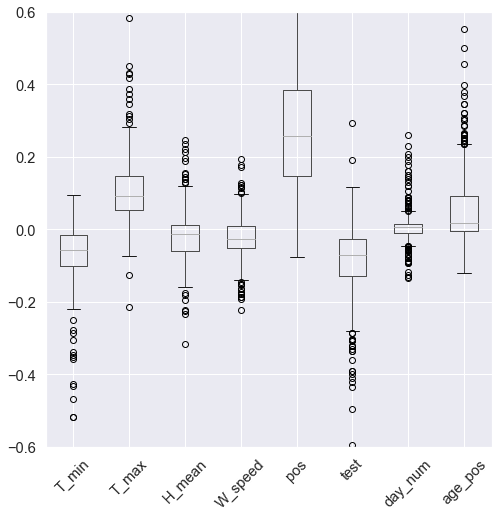

In [267]:
fig = plt.figure(figsize=(8, 8))
boxplot = df_grads.boxplot(rot=45)
ax = fig.gca()
ax.set_ylim([-0.6, 0.6])